In [1]:
#Enable this to install required packages
import sys
!{sys.executable} -m pip install -r requirements.txt

    100% |████████████████████████████████| 18.9MB 25kB/s  eta 0:00:01   17% |█████▌                          | 3.3MB 41.0MB/s eta 0:00:01    27% |████████▋                       | 5.1MB 37.7MB/s eta 0:00:01    79% |█████████████████████████▌      | 15.0MB 32.9MB/s eta 0:00:01
    100% |████████████████████████████████| 1.4MB 342kB/s eta 0:00:01
    100% |████████████████████████████████| 17.0MB 26kB/s  eta 0:00:01   18% |██████                          | 3.2MB 29.3MB/s eta 0:00:01    36% |███████████▌                    | 6.1MB 30.8MB/s eta 0:00:01    69% |██████████████████████▍         | 11.9MB 28.3MB/s eta 0:00:01    85% |███████████████████████████▌    | 14.6MB 28.9MB/s eta 0:00:01
    100% |████████████████████████████████| 61kB 4.8MB/s eta 0:00:01
  Running setup.py bdist_wheel for alphalens ... done
  Stored in directory: /root/.cache/pip/wheels/77/1e/9a/223b4c94d7f564f25d94b48ca5b9c53e3034016ece3fd8c8c1
  Running setup.py bdist_wheel for nltk ... done
  Stored in directory: /r

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from bs4 import BeautifulSoup
import pickle
from tqdm import tqdm
import nltk
import time

In [3]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [4]:
cik_lookup = {
    'CTL':'0000018926',
    'TTWO':'0000946581',
    'NI':'0001111711',
    'XPO':'0001166003',
    'IONS':'0000874015',
    'CZR':'0000858339',
    'BHF':'0001685040',
    'PODD':'0001145197',
    'FND':'0001507079',
    'WMB':'0001674168',
    'AMZN': '0001018724',
    'BMY': '0000014272',   
    'CNP': '0001130310',
    'CVX': '0000093410'}

### Get list of 10-ks
The SEC has a limit on the number of calls you can make to the website per second. In order to avoid hiding that limit, we've created the `SecAPI` class. This will cache data from the SEC and prevent you from going over the limit.

In [5]:
import requests
from ratelimit import limits, sleep_and_retry

class SecAPI(object):
    SEC_CALL_LIMIT = {'calls': 10, 'seconds': 1}

    @staticmethod
    @sleep_and_retry
    # Dividing the call limit by half to avoid coming close to the limit
    @limits(calls=SEC_CALL_LIMIT['calls'] / 2, period=SEC_CALL_LIMIT['seconds'])
    def _call_sec(url):
        return requests.get(url)

    def get(self, url):
        return self._call_sec(url).text

In [6]:
sec_api = SecAPI()

In [7]:
#Gets the URLS to download the Documents
def get_sec_data(cik,doc_type,start=0,count=60):
    rss_url = 'https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany'\
    '&CIK={}&type={}&start={}&count={}&owner=exclude&output=atom'.format(cik, doc_type, start, count)
    
    sec_data  = sec_api.get(rss_url)
    feed = BeautifulSoup(sec_data.encode('ascii'),'xml').feed
    entries = [(entry.content.find('filing-href').getText(),
                entry.content.find('filing-type').getText(),
                entry.content.find('filing-date').getText())
               for entry in feed.find_all('entry',recursive=False)]
    return entries
    

## Pull in  URLS from SEC
Gets the URLS to download the Documents

In [8]:
#These are the URL where it will be pinged from
start = time.time()
count = 50
example_ticker = 'CTL'
sec_data = {}

for ticker, cik in cik_lookup.items():
    sec_data[ticker] = get_sec_data(cik,'10-Q',count=count)
print(sec_data[example_ticker][:10])
print(sec_data[example_ticker][-10:])
end = time.time()
print('Took ' ,end-start,' Seconds')

[('https://www.sec.gov/Archives/edgar/data/18926/000001892618000029/0000018926-18-000029-index.htm', '10-Q', '2018-11-09'), ('https://www.sec.gov/Archives/edgar/data/18926/000001892618000023/0000018926-18-000023-index.htm', '10-Q', '2018-08-09'), ('https://www.sec.gov/Archives/edgar/data/18926/000001892618000020/0000018926-18-000020-index.htm', '10-Q', '2018-05-10'), ('https://www.sec.gov/Archives/edgar/data/18926/000001892617000074/0000018926-17-000074-index.htm', '10-Q', '2017-11-09'), ('https://www.sec.gov/Archives/edgar/data/18926/000001892617000055/0000018926-17-000055-index.htm', '10-Q', '2017-08-07'), ('https://www.sec.gov/Archives/edgar/data/18926/000001892617000023/0000018926-17-000023-index.htm', '10-Q', '2017-05-05'), ('https://www.sec.gov/Archives/edgar/data/18926/000001892616000070/0000018926-16-000070-index.htm', '10-Q', '2016-11-04'), ('https://www.sec.gov/Archives/edgar/data/18926/000001892616000062/0000018926-16-000062-index.htm', '10-Q', '2016-08-04'), ('https://www.s

### Download 10-s
As you see, this is a list of urls. These urls point to a file that contains metadata related to each filling. Since we don't care about the metadata, we'll pull the filling by replacing the url with the filling url.

In [9]:
start = time.time()
raw_fillings_by_ticker = {}

for ticker, data in sec_data.items():
    raw_fillings_by_ticker[ticker] = {}
    for index_url, file_type, file_date in tqdm(data, desc='Downloading {} Fillings'.format(ticker), unit='filling'):
        if (file_type == '10-Q'):
            file_url = index_url.replace('-index.htm', '.txt').replace('.txtl', '.txt')            
            
            raw_fillings_by_ticker[ticker][file_date] = sec_api.get(file_url)


print('Example Document:\n\n{}...'.format(next(iter(raw_fillings_by_ticker[example_ticker].values()))[:2000]))

end = time.time()
print('Took ' ,end-start,' Seconds')

Example Document:

<SEC-DOCUMENT>0000018926-18-000029.txt : 20181109
<SEC-HEADER>0000018926-18-000029.hdr.sgml : 20181109
<ACCEPTANCE-DATETIME>20181109162800
ACCESSION NUMBER:		0000018926-18-000029
CONFORMED SUBMISSION TYPE:	10-Q
PUBLIC DOCUMENT COUNT:		85
CONFORMED PERIOD OF REPORT:	20180930
FILED AS OF DATE:		20181109
DATE AS OF CHANGE:		20181109

FILER:

	COMPANY DATA:	
		COMPANY CONFORMED NAME:			CENTURYLINK, INC
		CENTRAL INDEX KEY:			0000018926
		STANDARD INDUSTRIAL CLASSIFICATION:	TELEPHONE COMMUNICATIONS (NO RADIO TELEPHONE) [4813]
		IRS NUMBER:				720651161
		STATE OF INCORPORATION:			LA
		FISCAL YEAR END:			1231

	FILING VALUES:
		FORM TYPE:		10-Q
		SEC ACT:		1934 Act
		SEC FILE NUMBER:	001-07784
		FILM NUMBER:		181173448

	BUSINESS ADDRESS:	
		STREET 1:		P O BOX 4065
		STREET 2:		100 CENTURYLINK DR
		CITY:			MONROE
		STATE:			LA
		ZIP:			71203
		BUSINESS PHONE:		3183889000

	MAIL ADDRESS:	
		STREET 1:		100 CENTURYLINK DR
		STREET 2:		P O BOX 4065
		CITY:			MONROE
		STATE:			

### Get Documents
With theses fillings downloaded, we want to break them into their associated documents. These documents are sectioned off in the fillings with the tags `<DOCUMENT>` for the start of each document and `</DOCUMENT>` for the end of each document. There's no overlap with these documents, so each `</DOCUMENT>` tag should come after the `<DOCUMENT>` with no `<DOCUMENT>` tag in between.

Implement `get_documents` to return a list of these documents from a filling. Make sure not to include the tag in the returned document text.

In [10]:
import re

def get_documents(text):
    """
    Extract the documents from the text

    Parameters
    ----------
    text : str
        The text with the document strings inside

    Returns
    -------
    extracted_docs : list of str
        The document strings found in `text`
     """
    return re.compile('<DOCUMENT>(.*?)</DOCUMENT>', re.DOTALL).findall(text)

In [11]:
start = time.time()

filling_documents_by_ticker = {}

for ticker, raw_fillings in raw_fillings_by_ticker.items():
    filling_documents_by_ticker[ticker] = {}
    for file_date, filling in tqdm(raw_fillings.items(),desc='Getting Documents from {} Fillings'.format(ticker), unit='filling'):
        filling_documents_by_ticker[ticker][file_date] = get_documents(filling)
        
print('\n\n'.join([
    'Document {} Filed on {}:\n{}...'.format(doc_i, file_date, doc[:200])
    for file_date, docs in filling_documents_by_ticker[example_ticker].items()
    for doc_i, doc in enumerate(docs)][:3]))

end = time.time()
print('Took ' ,end-start,' Seconds')

Getting Documents from CVX Fillings: 100%|██████████| 40/40 [00:18<00:00,  2.17filling/s]


Document 0 Filed on 2018-11-09:

<TYPE>10-Q
<SEQUENCE>1
<FILENAME>ctl2018093010q.htm
<DESCRIPTION>10-Q
<TEXT>
<!DOCTYPE html PUBLIC "-//W3C//DTD HTML 4.01 Transitional//EN" "http://www.w3.org/TR/html4/loose.dtd">
<html>
	<head>
		<!...

Document 1 Filed on 2018-11-09:

<TYPE>EX-31.1
<SEQUENCE>2
<FILENAME>ctl2018093010qex311.htm
<DESCRIPTION>EXHIBIT 31.1
<TEXT>
<!DOCTYPE html PUBLIC "-//W3C//DTD HTML 4.01 Transitional//EN" "http://www.w3.org/TR/html4/loose.dtd">
<ht...

Document 2 Filed on 2018-11-09:

<TYPE>EX-31.2
<SEQUENCE>3
<FILENAME>ctl2018093010qex312.htm
<DESCRIPTION>EXHIBIT 31.2
<TEXT>
<!DOCTYPE html PUBLIC "-//W3C//DTD HTML 4.01 Transitional//EN" "http://www.w3.org/TR/html4/loose.dtd">
<ht...
Took  109.75899505615234  Seconds


In [12]:
print('\n\n'.join([
    'Document {} Filed on {}:\n{}...'.format(doc_i, file_date, doc[:200])
    for file_date, docs in filling_documents_by_ticker[example_ticker].items()
    for doc_i, doc in enumerate(docs)][-3:]))

Document 3 Filed on 2006-05-03:

<TYPE>EX-31.2
<SEQUENCE>4
<FILENAME>exhibit31-2.htm
<DESCRIPTION>EXHIBIT 31.2
<TEXT>
<html>
  <head>
    <title>
      Exhibit 31.2
</title>
<!-- Licensed to: CenturyTel, Inc.-->
<!-- Document Create...

Document 4 Filed on 2006-05-03:

<TYPE>EX-32
<SEQUENCE>5
<FILENAME>exhibit32.htm
<DESCRIPTION>EXHIBIT 32
<TEXT>
<html>
  <head>
    <title>
      Exhibit 32
</title>
<!-- Licensed to: CenturyTel, Inc.-->
<!-- Document Created using ...

Document 5 Filed on 2006-05-03:

<TYPE>10-Q
<SEQUENCE>6
<FILENAME>submissionpdf.pdf
<DESCRIPTION>2006 1ST QTR 10Q
<TEXT>
<PDF>
begin 644 submissionpdf.pdf
M)5!$1BTQ+C$-"@T*-34@,"!O8FH-"CP\#0HO12`S-3<P#0HO2"!;(#DW-B`R
M-3,@70T*+TP@,3...


### Get Document Types
Now that we have all the documents, we want to find the 10 form in this 10 filing. Implement the `get_document_type` function to return the type of document given. The document type is located on a line with the `<TYPE>` tag. For example, a form of type "TEST" would have the line `<TYPE>TEST`. Make sure to return the type as lowercase, so this example would be returned as "test".

In [13]:
def get_document_type(doc):
    """
    Return the document type lowercased

    Parameters
    ----------
    doc : str
        The document string

    Returns
    -------
    doc_type : str
        The document type lowercased
    """
    
    # TODO: Implement
    doc_type = re.compile(r'<TYPE>[^\n]+')

    doc_types = [x[len('<TYPE>'):].lower() for x in doc_type.findall(doc)]            
                   
    return doc_types[0]

In [14]:
start = time.time()

ten_ticker = {}
doctype = '10-q'
for ticker, filling_documents in filling_documents_by_ticker.items():
    ten_ticker[ticker] = [] 
    for file_date, documents in filling_documents.items():
        for documents in documents:
            if get_document_type(documents) ==doctype:
                ten_ticker[ticker].append({
                    'cik':cik_lookup[ticker],
                    'file':documents,
                    'file_date': file_date})
                
end = time.time()
print('Took ' ,end-start,' Seconds')

Took  76.0780611038208  Seconds


### Function to check the file dates

In [15]:
#Function makes it eaiser to read files
def print_ten_k_data(ten_k_data, fields, field_length_limit=100):
    indentation = '  '

    print('[')
    for ten_k in ten_k_data:
        print_statement = '{}{{'.format(indentation)
        for field in fields:
            value = str(ten_k[field])

            # Show return lines in output
            if isinstance(value, str):
                value_str = '\'{}\''.format(value.replace('\n', '\\n'))
            else:
                value_str = str(value)

            # Cut off the string if it gets too long
            if len(value_str) > field_length_limit:
                value_str = value_str[:field_length_limit] + '...'

            print_statement += '\n{}{}: {}'.format(indentation * 2, field, value_str)

        print_statement += '},'
        print(print_statement)
    print(']')

In [16]:
print_ten_k_data(ten_ticker[example_ticker][:2], ['cik', 'file', 'file_date'])

[
  {
    cik: '0000018926'
    file: '\n<TYPE>10-Q\n<SEQUENCE>1\n<FILENAME>ctl2018093010q.htm\n<DESCRIPTION>10-Q\n<TEXT>\n<!DOCTYPE html ...
    file_date: '2018-11-09'},
  {
    cik: '0000018926'
    file: '\n<TYPE>10-Q\n<SEQUENCE>1\n<FILENAME>ctl2018063010q.htm\n<DESCRIPTION>10-Q\n<TEXT>\n<!DOCTYPE html ...
    file_date: '2018-08-09'},
]


## Preprocess the Data
### Clean Up
As you can see, the text for the documents are very messy. To clean this up, we'll remove the html and lowercase all the text.

In [17]:
def remove_html_tags(text):
    text = BeautifulSoup(text, 'html.parser').get_text()
    
    return text


def clean_text(text):
    text = text.lower()
    text = remove_html_tags(text)
    
    return text

### Before HTML Tags were removed

In [18]:
print_ten_k_data(ten_ticker[example_ticker][0:1], ['file'],field_length_limit=200)     

[
  {
    file: '\n<TYPE>10-Q\n<SEQUENCE>1\n<FILENAME>ctl2018093010q.htm\n<DESCRIPTION>10-Q\n<TEXT>\n<!DOCTYPE html PUBLIC "-//W3C//DTD HTML 4.01 Transitional//EN" "http://www.w3.org/TR/html4/loose.dtd">\n<html>\n	<h...},
]


In [19]:
start = time.time()

for ticker, ten in ten_ticker.items():
    for ten_d in tqdm(ten, desc='Cleaning {} 10-Ks'.format(ticker), unit='10-K'):
        ten_d['file_clean'] = clean_text(ten_d['file'])
print_ten_k_data(ten_ticker[example_ticker][:5], ['file_clean'])        

end = time.time()
print('Took ' ,end-start,' Seconds')

Cleaning CVX 10-Ks: 100%|██████████| 40/40 [00:45<00:00,  1.13s/10-K]

[
  {
    file_clean: '\n10-q\n1\nctl2018093010q.htm\n10-q\n\n\n\n\n\n\ndocument\n\n\ntable of contents united statessecur...},
  {
    file_clean: '\n10-q\n1\nctl2018063010q.htm\n10-q\n\n\n\n\n\n\ndocument\n\n\ntable of contents united statessecur...},
  {
    file_clean: '\n10-q\n1\nctl2018033110q.htm\n10-q\n\n\n\n\n\n\ndocument\n\n\n united statessecurities and exchang...},
  {
    file_clean: '\n10-q\n1\nctl2017093010q.htm\n10-q\n\n\n\n\n\n\ndocument\n\n\n united statessecurities and exchang...},
  {
    file_clean: '\n10-q\n1\nctl2017063010q.htm\n10-q\n\n\n\n\n\n\ndocument\n\n\n united statessecurities and exchang...},
]
Took  600.636091709137  Seconds


### After HTML Tags were removed

In [20]:
print_ten_k_data(ten_ticker[example_ticker][:5], ['file_clean'],field_length_limit=200)     

[
  {
    file_clean: '\n10-q\n1\nctl2018093010q.htm\n10-q\n\n\n\n\n\n\ndocument\n\n\ntable of contents united statessecurities and exchange commissionwashington, d.c. 20549 form 10-q ýquarterly report pursuant to section ...},
  {
    file_clean: '\n10-q\n1\nctl2018063010q.htm\n10-q\n\n\n\n\n\n\ndocument\n\n\ntable of contents united statessecurities and exchange commissionwashington, d.c. 20549 form 10-q ýquarterly report pursuant to section ...},
  {
    file_clean: '\n10-q\n1\nctl2018033110q.htm\n10-q\n\n\n\n\n\n\ndocument\n\n\n united statessecurities and exchange commissionwashington, d.c. 20549 form 10-q ýquarterly report pursuant to section 13 or 15(d) of th...},
  {
    file_clean: '\n10-q\n1\nctl2017093010q.htm\n10-q\n\n\n\n\n\n\ndocument\n\n\n united statessecurities and exchange commissionwashington, d.c. 20549 form 10-q ýquarterly report pursuant to section 13 or 15(d) of th...},
  {
    file_clean: '\n10-q\n1\nctl2017063010q.htm\n10-q\n\n\n\n\n\n\ndocument\n\n\n united st

### Lemmatize
Map words back to orginal root

In [21]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

def lemmatize_words(words, how='v'):
    """
    Lemmatize words 

    Parameters
    ----------
    words : list of str
        List of words

    Returns
    -------
    lemmatized_words : list of str
        List of lemmatized words
    """
    return [WordNetLemmatizer().lemmatize(w,pos=how) for w in words]


In [22]:
LemmaHow = 'n'
word_pattern=re.compile('\w+')

for ticker, ten__ in ten_ticker.items():
    for ten_ in tqdm(ten__, desc='Lemmatize {} 10-s'.format(ticker), unit='10-s'):
         ten_['file_lemma'] = lemmatize_words(word_pattern.findall(ten_['file_clean']),LemmaHow)
print_ten_k_data(ten_ticker[example_ticker][:3], ['file_lemma'])

Lemmatize CVX 10-s: 100%|██████████| 40/40 [00:06<00:00,  6.4410-s/s]


[
  {
    file_lemma: '['10', 'q', '1', 'ctl2018093010q', 'htm', '10', 'q', 'document', 'table', 'of', 'content', 'united'...},
  {
    file_lemma: '['10', 'q', '1', 'ctl2018063010q', 'htm', '10', 'q', 'document', 'table', 'of', 'content', 'united'...},
  {
    file_lemma: '['10', 'q', '1', 'ctl2018033110q', 'htm', '10', 'q', 'document', 'united', 'statessecurities', 'and...},
]


### Result After Lemmatization

In [23]:
print_ten_k_data(ten_ticker[example_ticker][:3], ['file_lemma'],field_length_limit=200) 

[
  {
    file_lemma: '['10', 'q', '1', 'ctl2018093010q', 'htm', '10', 'q', 'document', 'table', 'of', 'content', 'united', 'statessecurities', 'and', 'exchange', 'commissionwashington', 'd', 'c', '20549', 'form', '10', 'q...},
  {
    file_lemma: '['10', 'q', '1', 'ctl2018063010q', 'htm', '10', 'q', 'document', 'table', 'of', 'content', 'united', 'statessecurities', 'and', 'exchange', 'commissionwashington', 'd', 'c', '20549', 'form', '10', 'q...},
  {
    file_lemma: '['10', 'q', '1', 'ctl2018033110q', 'htm', '10', 'q', 'document', 'united', 'statessecurities', 'and', 'exchange', 'commissionwashington', 'd', 'c', '20549', 'form', '10', 'q', 'ýquarterly', 'report',...},
]


### View StopWords

In [24]:
from nltk.corpus import stopwords
Stopdf = pd.DataFrame(stopwords.words('english'),columns=['StopWords'])
Stopdf['Index'] = Stopdf['StopWords']
Stopdf = Stopdf.set_index('Index')
Stopdf

,StopWords
Index,
i,i
me,me
my,my
myself,myself
we,we
our,our
ours,ours
ourselves,ourselves
you,you


### Remove Stopwords

In [25]:
lemma_english_stopwords = lemmatize_words(stopwords.words('english'),LemmaHow)

for ticker , ten__ in ten_ticker.items():
    for ten_ in tqdm(ten__, desc='Remove Stop Words for {} 10-Ks'.format(ticker), unit='10-K'):
        ten_['file_lemma'] = [word for word in ten_['file_lemma'] if word not in lemma_english_stopwords]

print('Stop Words Removed')        

Remove Stop Words for CVX 10-Ks: 100%|██████████| 40/40 [00:02<00:00, 15.1110-K/s]

Stop Words Removed


### Result After Stopwords

In [26]:
print_ten_k_data(ten_ticker[example_ticker][:3], ['file_lemma'],field_length_limit=200) 

[
  {
    file_lemma: '['10', 'q', '1', 'ctl2018093010q', 'htm', '10', 'q', 'document', 'table', 'content', 'united', 'statessecurities', 'exchange', 'commissionwashington', 'c', '20549', 'form', '10', 'q', 'ýquarterly', '...},
  {
    file_lemma: '['10', 'q', '1', 'ctl2018063010q', 'htm', '10', 'q', 'document', 'table', 'content', 'united', 'statessecurities', 'exchange', 'commissionwashington', 'c', '20549', 'form', '10', 'q', 'ýquarterly', '...},
  {
    file_lemma: '['10', 'q', '1', 'ctl2018033110q', 'htm', '10', 'q', 'document', 'united', 'statessecurities', 'exchange', 'commissionwashington', 'c', '20549', 'form', '10', 'q', 'ýquarterly', 'report', 'pursuant',...},
]


## Analysis on 10ks
### Loughran McDonald Sentiment Word Lists
We'll be using the Loughran and McDonald sentiment word lists. These word lists cover the following sentiment:
- Negative 
- Positive
- Uncertainty
- Litigious
- Constraining
- Superfluous
- Modal

This will allow us to do the sentiment analysis on the 10-ks. Let's first load these word lists. We'll be looking into a few of these sentiments.

### Sentiment Enabled

In [27]:
sentiments = ['negative', 'positive', 'uncertainty', 'litigious', 'constraining', 'interesting']

sentiment_df =pd.read_csv('loughran_mcdonald_master_dic_2016.csv')
sentiment_df.columns = [column.lower() for column in sentiment_df.columns]

#remove unsed information
sentiment_df = sentiment_df[sentiments + ['word']]
sentiment_df[sentiments] = sentiment_df[sentiments].astype(bool)
sentiment_df = sentiment_df[(sentiment_df[sentiments]).any(1)]

# Apply the same preprocessing to these words as the 10-k words
sentiment_df['word'] = lemmatize_words(sentiment_df['word'].str.lower(),LemmaHow)
sentiment_df = sentiment_df.drop_duplicates('word')


In [28]:
sentiment_df.head()

,negative,positive,uncertainty,litigious,constraining,interesting,word
9,True,False,False,False,False,False,abandon
10,True,False,False,False,False,False,abandoned
11,True,False,False,False,False,False,abandoning
12,True,False,False,False,False,False,abandonment
51,True,False,False,False,False,False,abdicated


In [29]:
sentiment_df.tail()

,negative,positive,uncertainty,litigious,constraining,interesting,word
84767,True,False,False,False,False,False,wrong
84770,True,False,False,False,False,False,wrongdoing
84775,True,False,False,False,False,False,wrongful
84776,True,False,False,False,False,False,wrongfully
84784,True,False,False,False,False,False,wrongly


### Allwords

In [30]:
allwords= ['negative', 'positive', 'uncertainty', 'litigious', 'constraining', 'interesting']

df =pd.read_csv('loughran_mcdonald_master_dic_2016.csv')
df.columns = [column.lower() for column in df.columns]
df = df[allwords + ['word']]
df['allwords'] =  df[allwords].sum(axis=1)
df = df[['allwords','word']]
df['allwords']=df['allwords'].astype(bool)
df['word'] = df['word'].str.lower()#lower case
df=df[df.word.notnull()==True]#Remove NANs
df.word = lemmatize_words(df['word'],LemmaHow)
df = df.drop_duplicates('word')
df.allwords= True

In [31]:
df.head()

,allwords,word
0,True,aardvark
2,True,abacus
3,True,aback
6,True,abaft
7,True,abalone


In [32]:
df.tail()

,allwords,word
85212,True,zwieback
85214,True,zydeco
85216,True,zygote
85218,True,zygotic
85219,True,zymurgy


### Bag of Words
using the sentiment word lists, let's generate sentiment bag of words from the 10-k documents. Implement `get_bag_of_words` to generate a bag of words that counts the number of sentiment words in each doc. You can ignore words that are not in `sentiment_words`.

In [33]:
from collections import defaultdict, Counter
from sklearn.feature_extraction.text import CountVectorizer

def get_bag_of_words(sentiment_words, docs):
    """
    Generate a bag of words from documents for a certain sentiment

    Parameters
    ----------
    sentiment_words: Pandas Series
        Words that signify a certain sentiment
    docs : list of str
        List of documents used to generate bag of words

    Returns
    -------
    bag_of_words : 2-d Numpy Ndarray of int
        Bag of words sentiment for each document
        The first dimension is the document.
        The second dimension is the word.
    """
    
    # TODO: Implement
    
    vectorizer = CountVectorizer(CountVectorizer(vocabulary=sentiment_words))
    #vectorizer = CountVectorizer()
    X = vectorizer.fit(sentiment_words)
    X = X.transform(docs)
    return X.toarray()

### Sentiment

In [34]:
sentiment_bow_ten = {}
for ticker, ten_ in ten_ticker.items():
    lemma_docs = [' '.join(ten['file_lemma']) for ten in ten_]
    
    sentiment_bow_ten[ticker] = {
        sentiment: get_bag_of_words(sentiment_df[sentiment_df[sentiment]]['word'],lemma_docs) for sentiment in sentiments}
    

In [35]:
print_ten_k_data([sentiment_bow_ten[example_ticker]], sentiments)

[
  {
    negative: '[[0 0 0 ..., 0 1 0]\n [0 0 0 ..., 0 1 0]\n [0 0 0 ..., 0 1 0]\n ..., \n [0 0 0 ..., 0 0 0]\n [0 0 0...
    positive: '[[1 0 0 ..., 0 0 0]\n [2 0 0 ..., 0 0 0]\n [3 0 0 ..., 0 0 0]\n ..., \n [0 0 0 ..., 0 0 0]\n [0 0 0...
    uncertainty: '[[0 0 0 ..., 0 0 2]\n [0 0 0 ..., 0 0 2]\n [0 0 0 ..., 0 0 2]\n ..., \n [0 0 0 ..., 0 0 0]\n [0 0 0...
    litigious: '[[0 0 0 ..., 0 0 0]\n [0 0 0 ..., 0 0 0]\n [0 0 0 ..., 0 0 0]\n ..., \n [0 0 0 ..., 0 0 0]\n [0 0 0...
    constraining: '[[0 0 0 ..., 0 0 1]\n [0 0 0 ..., 0 0 2]\n [0 0 0 ..., 0 0 2]\n ..., \n [0 0 0 ..., 0 0 0]\n [0 0 0...
    interesting: '[[0 0 0 ..., 0 0 0]\n [0 0 0 ..., 0 0 0]\n [0 0 0 ..., 0 0 0]\n ..., \n [0 0 0 ..., 0 0 0]\n [0 0 0...},
]


### Allwords

In [36]:
bow_ten = {}
allwords='allwords'
for ticker, ten_ in ten_ticker.items():
    lemma_docs = [' '.join(ten['file_lemma']) for ten in ten_]
    
    bow_ten[ticker] = {
        allwords: get_bag_of_words(df[df[allwords]]['word'],lemma_docs)}


### File date

In [37]:
# Get dates for the universe
file_dates = {
    ticker: [ten_['file_date'] for ten_ in ten]
    for ticker, ten in ten_ticker.items()}  

### Count of Allwords (BOW)

In [38]:
for ticker, ten_ in ten_ticker.items():
    if ticker == example_ticker:
        docs = [' '.join(ten['file_lemma']) for ten in ten_]
        

In [39]:
vectorizer = CountVectorizer(CountVectorizer(vocabulary=df[df[allwords]]['word']))
X = vectorizer.fit(df[df[allwords]]['word'])
WordName = X.get_feature_names()
X = X.transform(docs)

In [40]:
Word = pd.DataFrame(X.toarray(),columns=[WordName],index=file_dates[example_ticker])
Q22017 = Word.iloc[4]
Q22018 = Word.iloc[1]
countdf = pd.concat([Q22018,Q22017],axis=1)
WordCount = countdf.sort_values(by=countdf.columns[0],ascending=False)

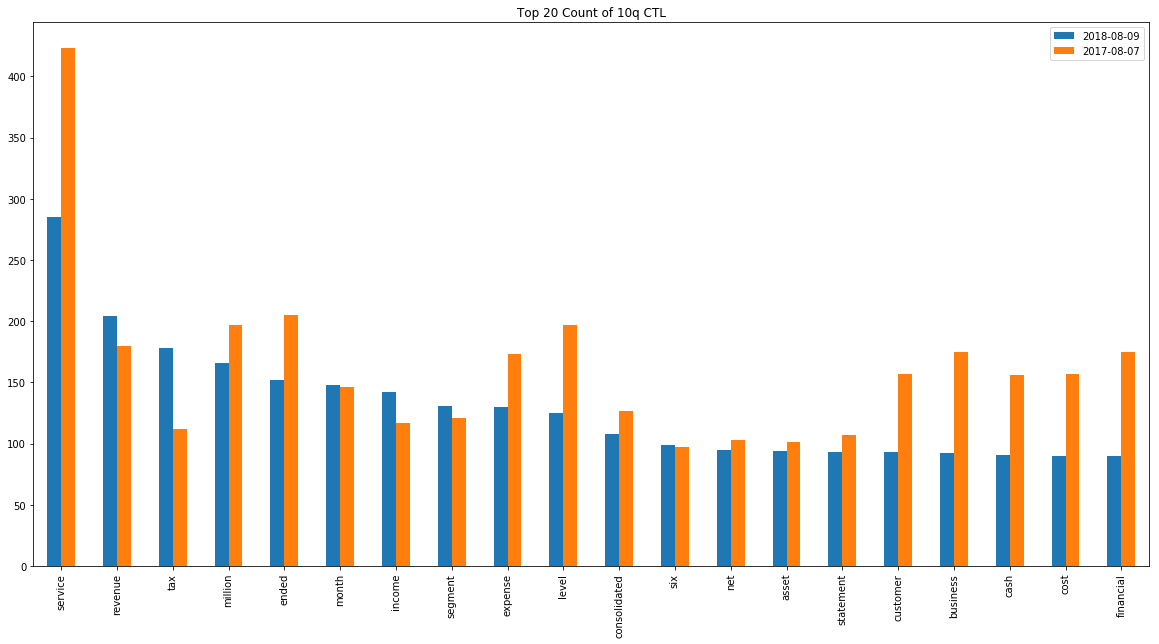

In [41]:
pd.DataFrame(WordCount[:20]).plot(kind='bar',figsize=(20,10),title='Top 20 Count of 10q '+example_ticker)

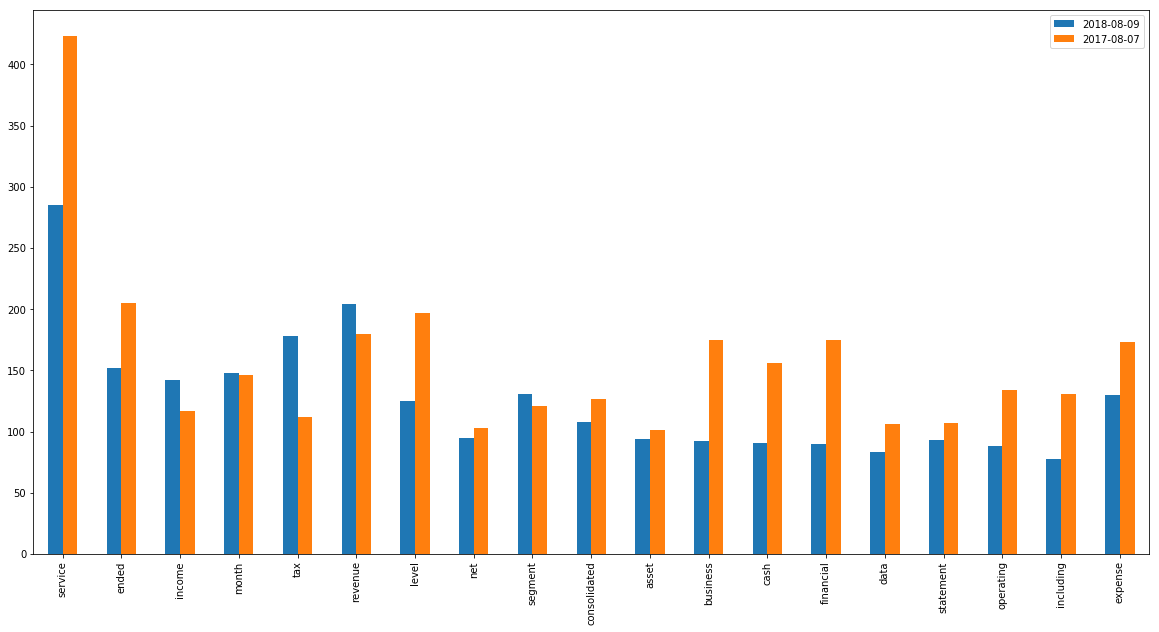

In [42]:
wd = ['service','ended','income','month','tax','revenue','level','net','segment','consolidated','asset','business','cash','financial','data','statement','operating','including','expense']
#WordCount.loc[wd]
pd.DataFrame(WordCount.loc[wd]).plot(kind='bar',figsize=(20,10))

### TFIDF
Change use_idf to false to diable idf

In [43]:
from sklearn.feature_extraction.text import TfidfVectorizer


def get_tfidf(sentiment_words, docs):
    """
    Generate TFIDF values from documents for a certain sentiment

    Parameters
    ----------
    sentiment_words: Pandas Series
        Words that signify a certain sentiment
    docs : list of str
        List of documents used to generate bag of words

    Returns
    -------
    tfidf : 2-d Numpy Ndarray of float
        TFIDF sentiment for each document
        The first dimension is the document.
        The second dimension is the word.
    """
    
    # TODO: Implement
    vectorizer = TfidfVectorizer(use_idf = False,sublinear_tf= True)
    X = vectorizer.fit(sentiment_words) 
    X = X.transform(docs)


    return X.toarray()


### Sentiment

In [44]:
start = time.time()
sentiment_tfidf_ten_ks = {}
for ticker, ten_ in ten_ticker.items():
    lemma_docs = [' '.join(ten['file_lemma']) for ten in ten_]
    
    sentiment_tfidf_ten_ks[ticker] = {
        sentiment: get_tfidf(sentiment_df[sentiment_df[sentiment]]['word'],lemma_docs) for sentiment in sentiments}

end = time.time()
print('Took ' ,end-start,' Seconds')    

Took  43.92647171020508  Seconds


In [45]:
print_ten_k_data([sentiment_tfidf_ten_ks[example_ticker]], sentiments)

[
  {
    negative: '[[ 0.          0.          0.         ...,  0.          0.05234547  0.        ]\n [ 0.          0. ...
    positive: '[[ 0.07548384  0.          0.         ...,  0.          0.          0.        ]\n [ 0.12609735  0. ...
    uncertainty: '[[ 0.          0.          0.         ...,  0.          0.          0.10209891]\n [ 0.          0. ...
    litigious: '[[ 0.  0.  0. ...,  0.  0.  0.]\n [ 0.  0.  0. ...,  0.  0.  0.]\n [ 0.  0.  0. ...,  0.  0.  0.]\n...
    constraining: '[[ 0.          0.          0.         ...,  0.          0.          0.0863594 ]\n [ 0.          0. ...
    interesting: '[[ 0.  0.  0. ...,  0.  0.  0.]\n [ 0.  0.  0. ...,  0.  0.  0.]\n [ 0.  0.  0. ...,  0.  0.  0.]\n...},
]


### Allwords

In [46]:
start = time.time()

tfidf_ten_ks = {}
for ticker, ten_ in ten_ticker.items():
    lemma_docs = [' '.join(ten['file_lemma']) for ten in ten_]
    
    tfidf_ten_ks[ticker] = {
        allwords: get_tfidf(df[df[allwords]]['word'],lemma_docs) for w in allwords}

end = time.time()
print('Took ' ,end-start,' Seconds')    

Took  108.7235209941864  Seconds


In [47]:
print_ten_k_data([bow_ten[example_ticker]], [allwords])

[
  {
    allwords: '[[0 0 0 ..., 0 0 0]\n [0 0 0 ..., 0 0 0]\n [0 0 0 ..., 0 0 0]\n ..., \n [0 0 0 ..., 0 0 0]\n [0 0 0...},
]


## Cosine Similarity
Using the TFIDF values, we'll calculate the cosine similarity and plot it over time. Implement `get_cosine_similarity` to return the cosine similarities between each tick in time. Since the input, `tfidf_matrix`, is a TFIDF vector for each time period in order, you just need to computer the cosine similarities for each neighboring vector.

In [48]:
#Adjust Ticker
print(cik_lookup.keys())
example_ticker = 'CTL'

dict_keys(['CTL', 'TTWO', 'NI', 'XPO', 'IONS', 'CZR', 'BHF', 'PODD', 'FND', 'WMB', 'AMZN', 'BMY', 'CNP', 'CVX'])


### Seasonality Adjusted

In [49]:
from sklearn.metrics.pairwise import cosine_similarity

def get_cosine_similarity(tfidf_matrix):
    """
    Get cosine similarities for each neighboring TFIDF vector/document

    Parameters
    ----------
    tfidf : 2-d Numpy Ndarray of float
        TFIDF sentiment for each document
        The first dimension is the document.
        The second dimension is the word.

    Returns
    -------
    cosine_similarities : list of float
        Cosine similarities for neighboring documents
    """
    
    # TODO: Implement
 
    cos_sim=[]
    for i in range(len(tfidf_matrix)-3):
        cos_sim.append(cosine_similarity(tfidf_matrix)[i][i+3])

    return cos_sim

#### Sentiment Seasonality Adjusted

In [50]:
# Get dates for the universe
file_dates = {
    ticker: [ten_['file_date'] for ten_ in ten]
    for ticker, ten in ten_ticker.items()}  

In [51]:
cosine_similarities = {
    ticker: {
        sentiment_name: get_cosine_similarity(sentiment_values)
        for sentiment_name, sentiment_values in ten_k_sentiments.items()}
    for ticker, ten_k_sentiments in sentiment_tfidf_ten_ks.items()}


In [52]:
#View Data points
cosdf = pd.DataFrame(cosine_similarities[example_ticker])
cosdf['FileDate'] = file_dates[example_ticker][:-3]
cosdf['FileDate']=cosdf['FileDate'].astype('datetime64[ns]')
cosdf['Qdate'] = [('Q'+str(x.quarter-1))+str(x.year) for x in cosdf['FileDate']] #Apply Qdate
cosdf=cosdf.sort_values(by='FileDate')
#cosdf=cosdf.set_index('FileDate')
cosdf=cosdf.set_index('Qdate')
cosdf

,constraining,interesting,litigious,negative,positive,uncertainty,FileDate
Qdate,,,,,,,
Q22006,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2006-08-03
Q32006,0.955616,0.932634,0.973511,0.888365,0.946042,0.987160,2006-11-08
Q12007,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2007-05-09
Q22007,0.921430,0.987038,0.918439,0.816181,0.983842,0.922727,2007-08-08
Q32007,0.949984,0.989046,0.877347,0.836327,0.953956,0.921720,2007-11-07
Q12008,0.974533,0.993727,0.874652,0.836966,0.926872,0.971503,2008-05-07
Q22008,0.939713,0.989923,0.880601,0.774999,0.927895,0.958406,2008-08-01
Q32008,0.923809,0.953618,0.844664,0.746441,0.941719,0.937478,2008-10-31
Q12009,0.945822,0.959692,0.926105,0.869524,0.915544,0.907130,2009-05-01


### Plots Sentiment Seasonality Adjusted

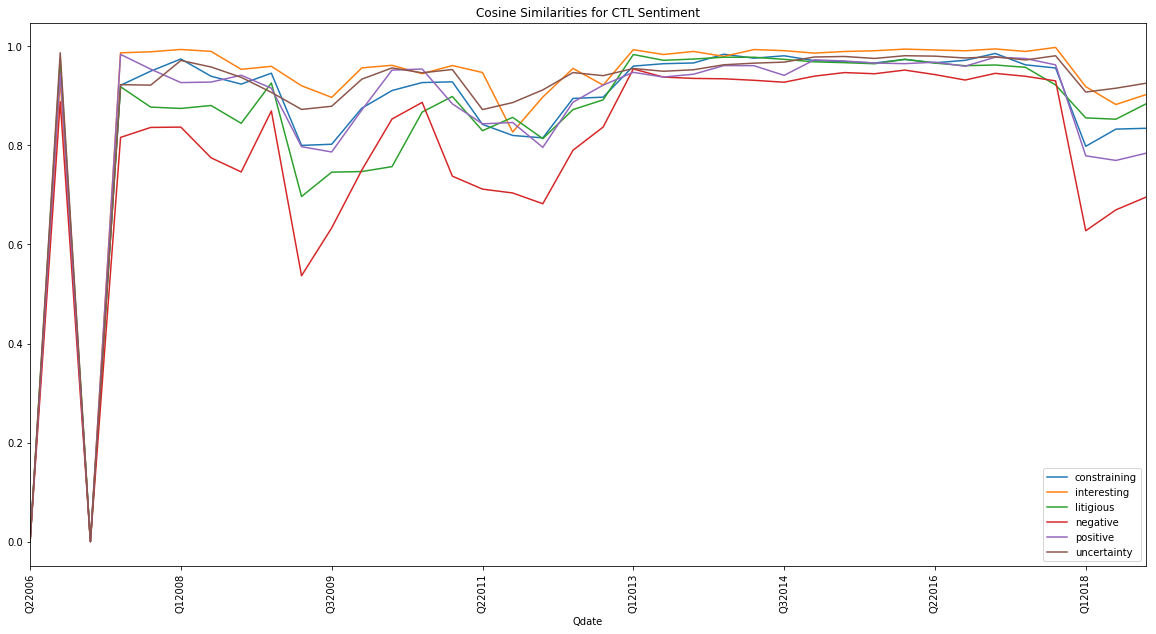

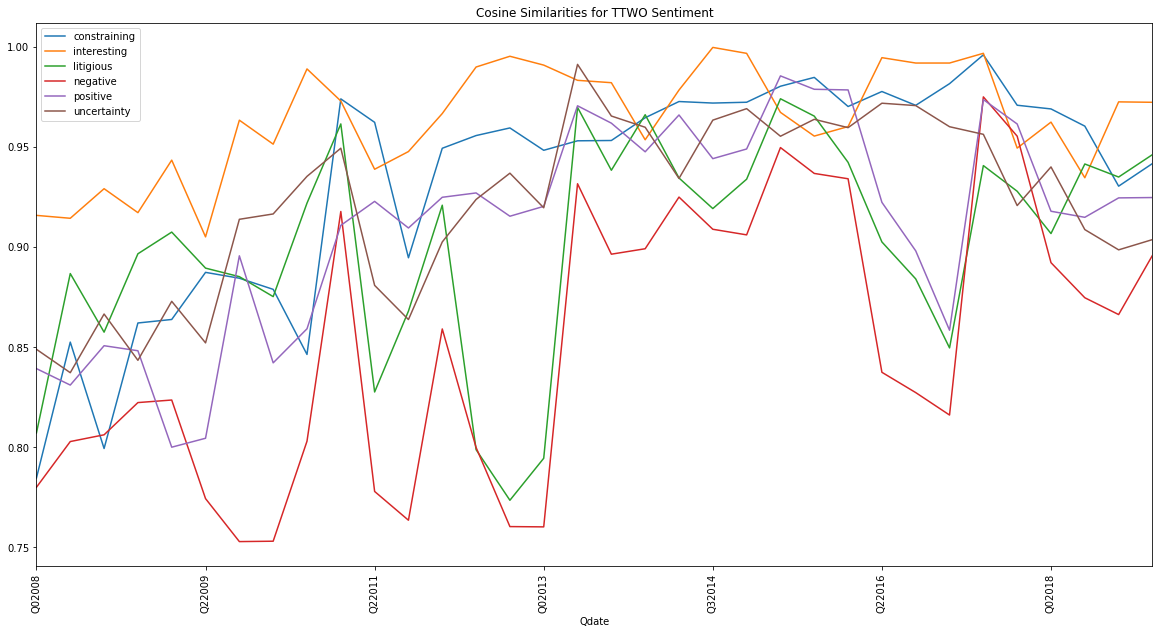

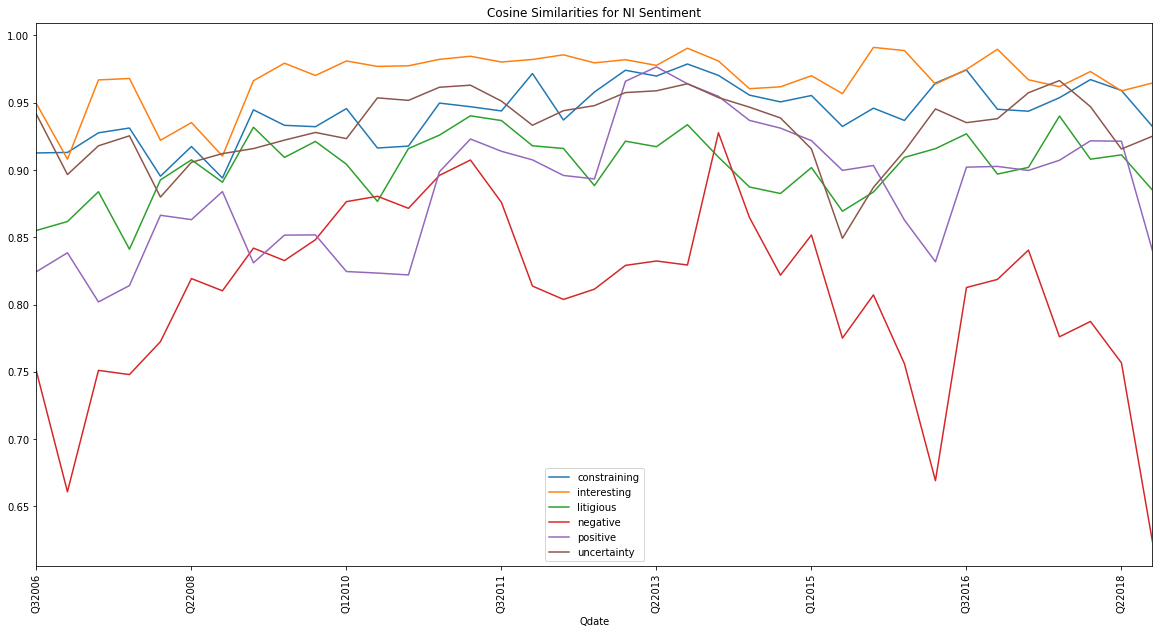

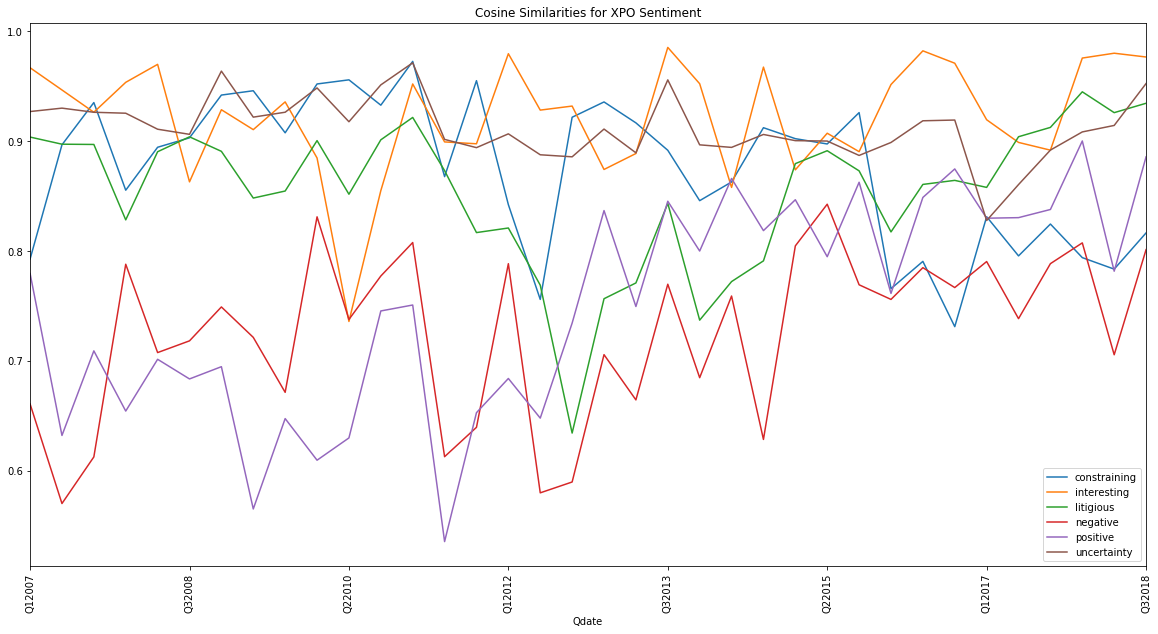

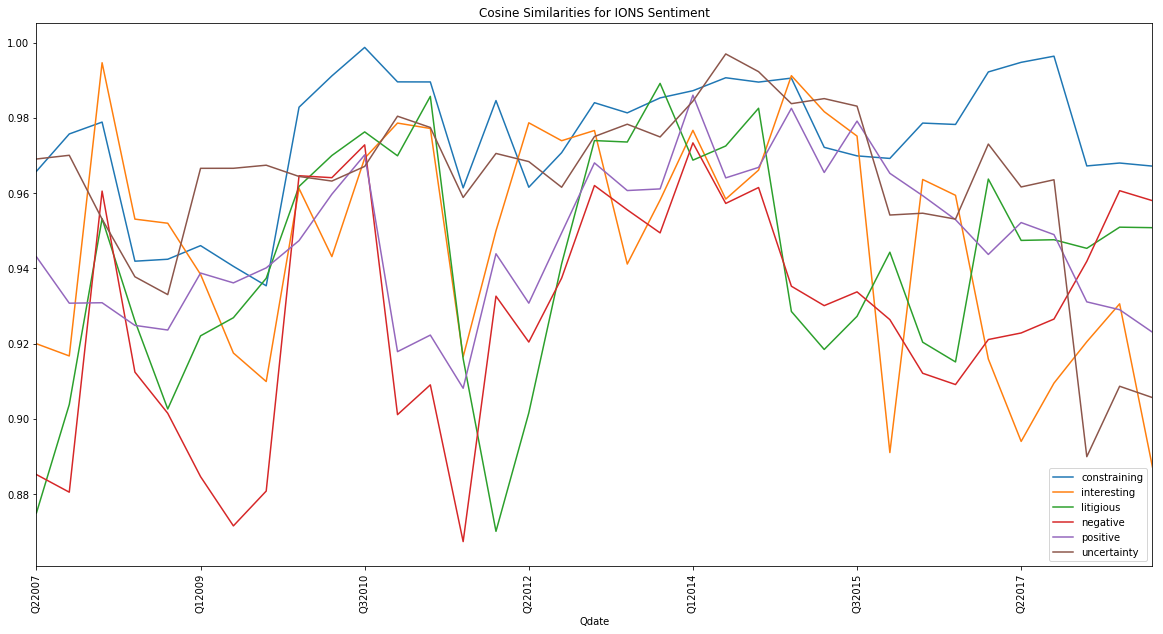

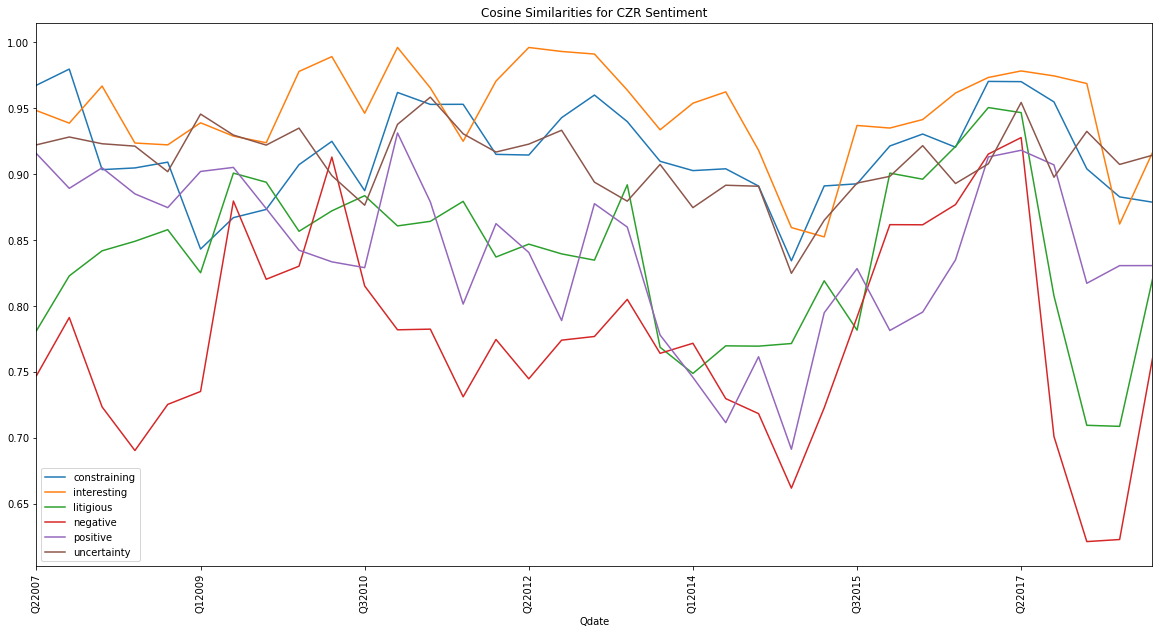

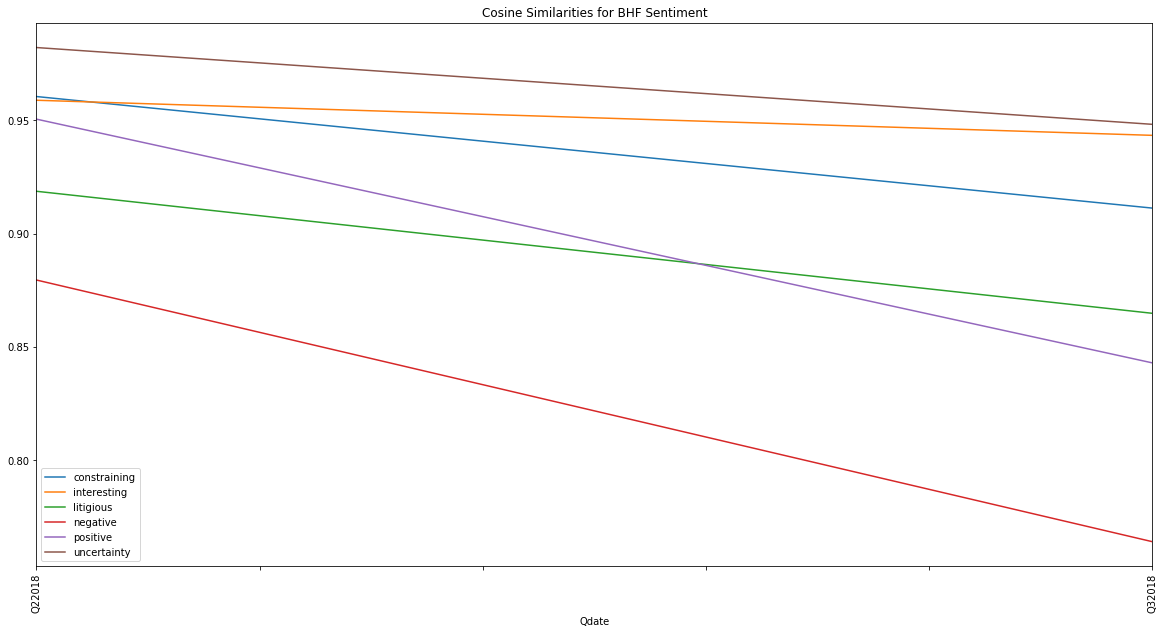

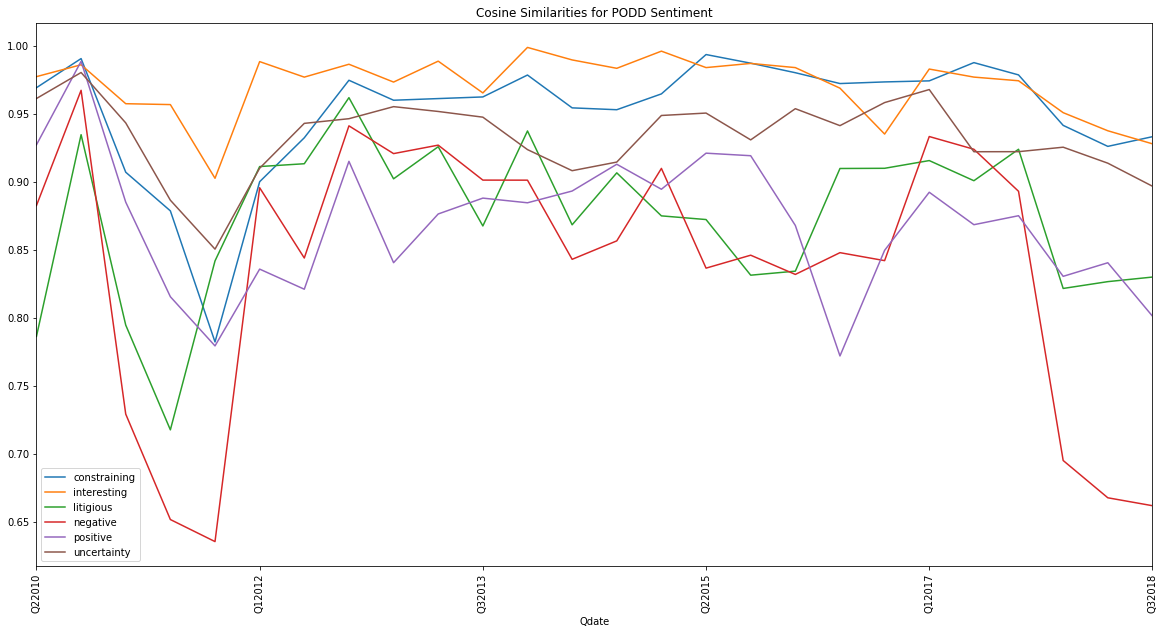

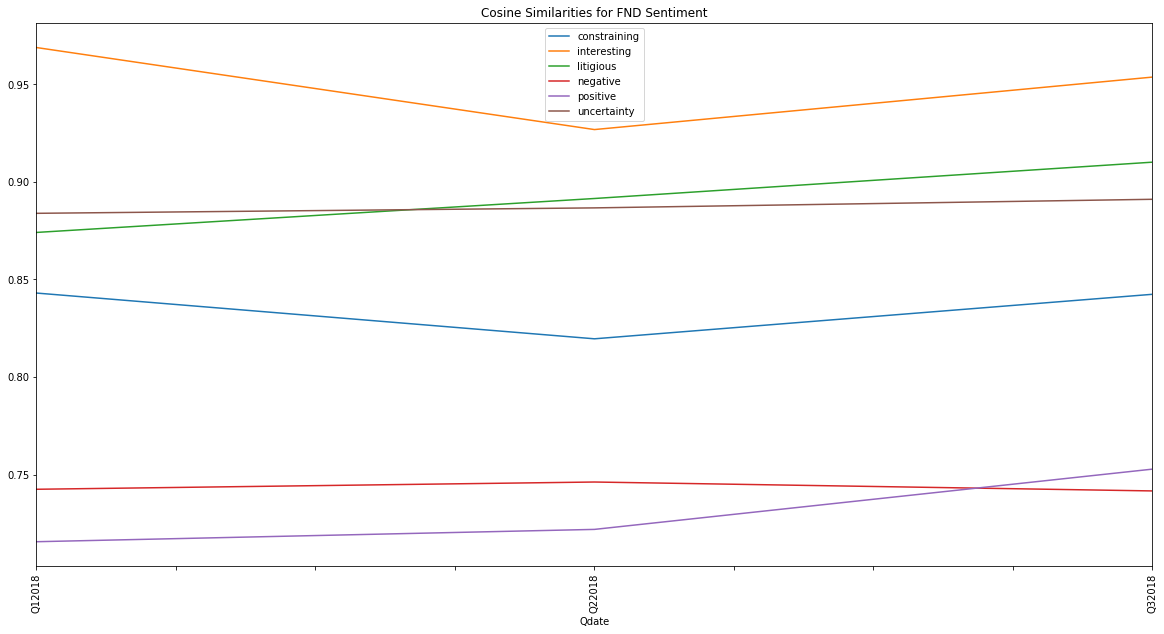

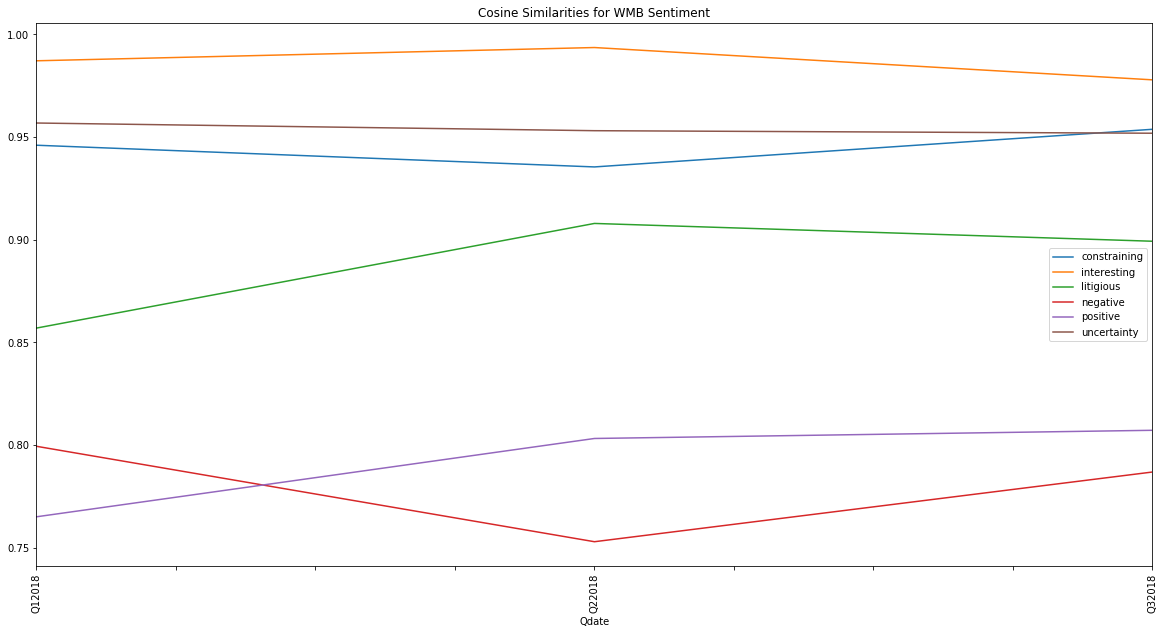

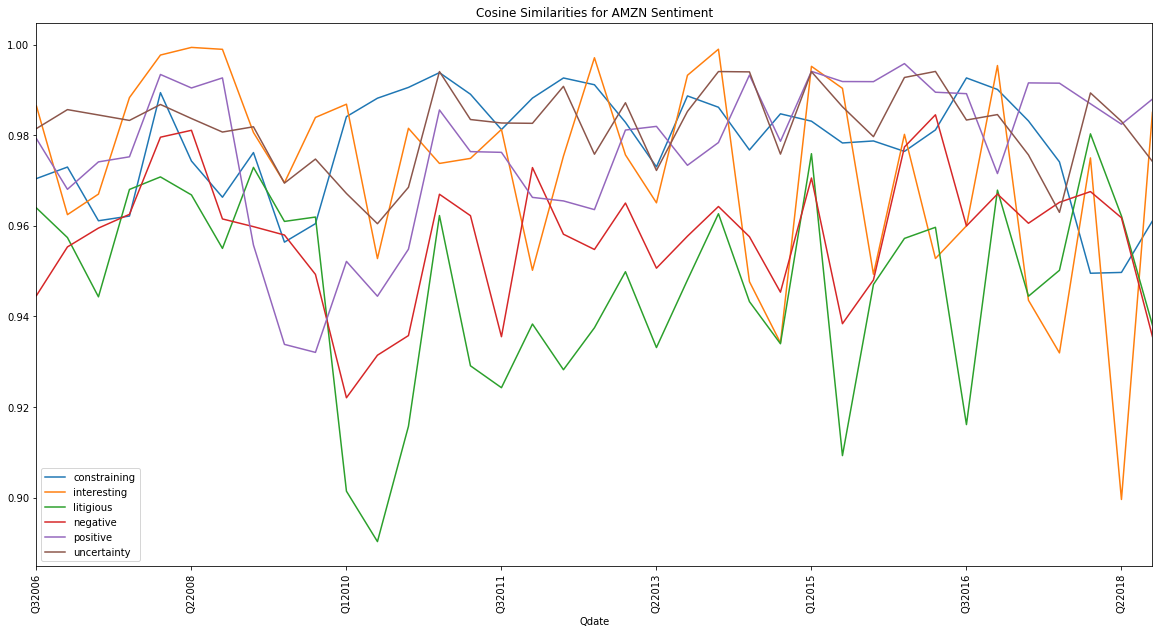

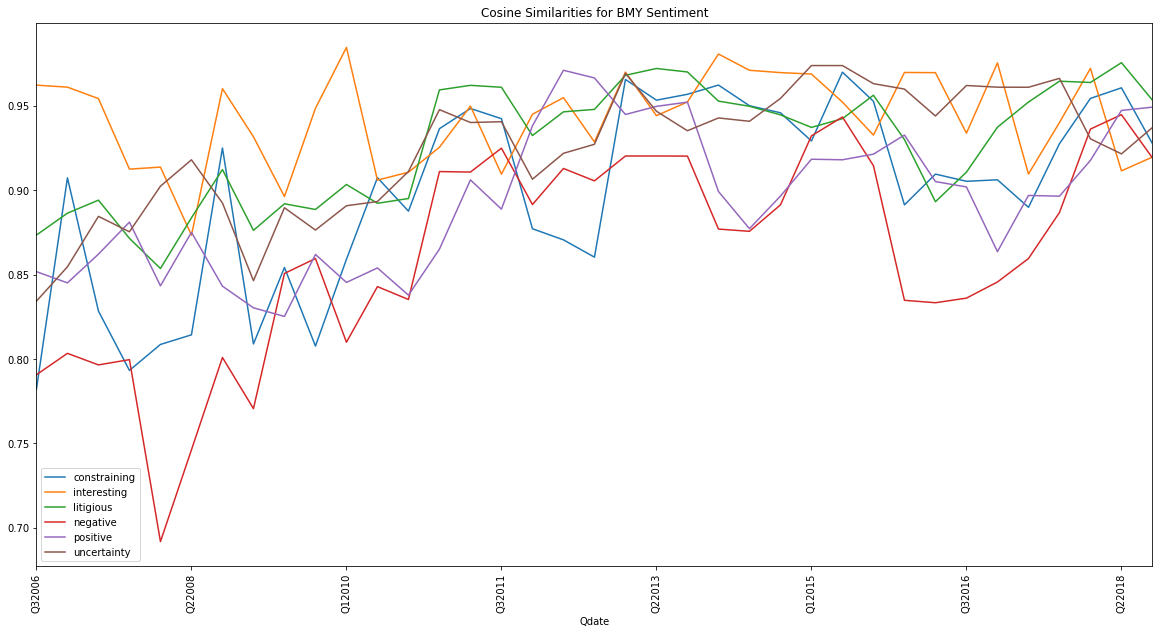

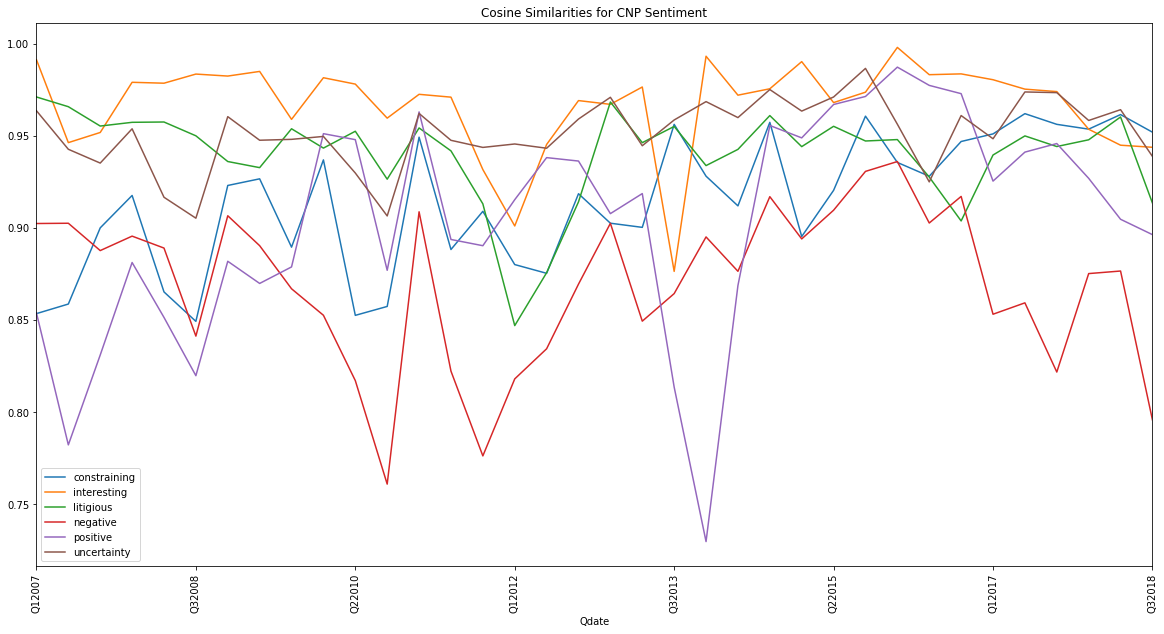

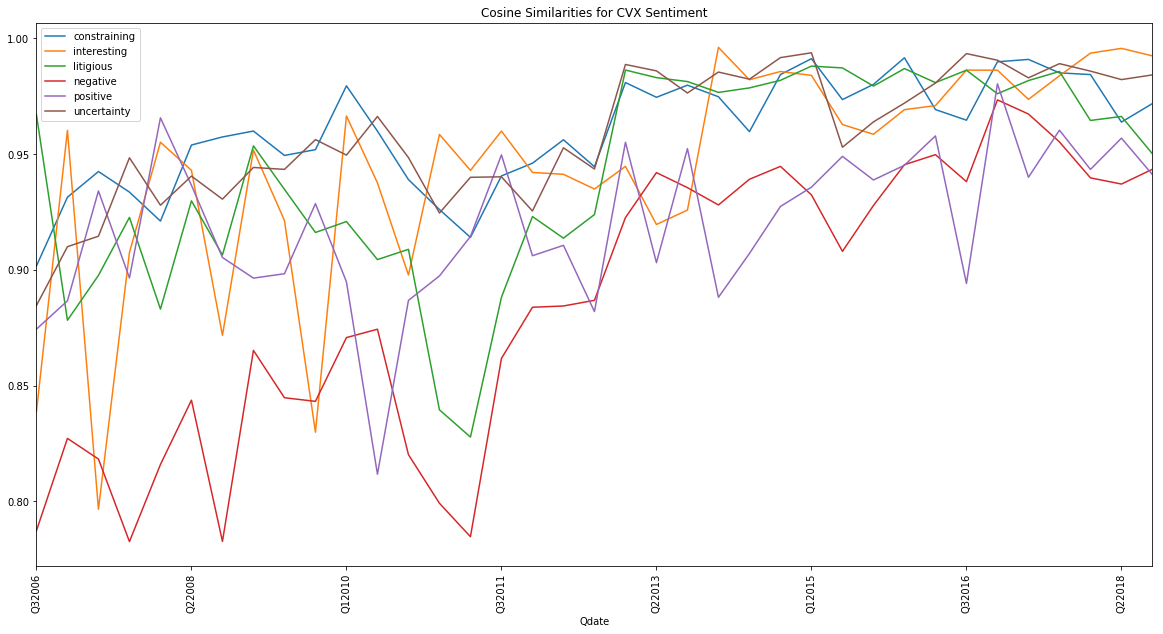

In [53]:
import matplotlib.dates as mdates
for tickers in cik_lookup.keys():
    example_ticker = tickers
    
    cosdf = pd.DataFrame(cosine_similarities[example_ticker])
    cosdf['FileDate'] = file_dates[example_ticker][:-3]
    cosdf['FileDate']=cosdf['FileDate'].astype('datetime64[ns]')
    cosdf['Qdate'] = [('Q'+str(x.quarter-1)+str(x.year)) for x in cosdf['FileDate']] #Applu Qdate
    cosdf=cosdf.sort_values(by='FileDate')
    #cosdf=cosdf.set_index('FileDate')
    cosdf=cosdf.set_index('Qdate')
    
    ax = cosdf.plot(figsize=(20,10),title='Cosine Similarities for {} Sentiment'.format(example_ticker),xticks=None,
              fontsize=10,x_compat=True)
  #  labels = [l.strftime('%m-%y') for l in cosdf.index]
 #   ax.set_xticks(cosdf.index)
  #  ax.set_xticklabels(labels)
    plt.xticks(rotation=90)
    plt.show()
    

#### Allwords Seasonality Adjusted

In [54]:
# Get dates for the universe
file_dates = {
    ticker: [ten_['file_date'] for ten_ in ten]
    for ticker, ten in ten_ticker.items()}  

cosine_similarities = {
    ticker: {
        _name: get_cosine_similarity(_values)
        for _name, _values in ten_k_.items()}
    for ticker, ten_k_ in tfidf_ten_ks.items()}


In [55]:
#View Data points
cosdfallwords = pd.DataFrame(cosine_similarities[example_ticker])
cosdfallwords['FileDate'] = file_dates[example_ticker][:-3]
cosdfallwords['FileDate']=cosdfallwords['FileDate'].astype('datetime64[ns]')
cosdfallwords['Qdate'] = [('Q'+str(x.quarter-1))+str(x.year) for x in cosdfallwords['FileDate']] #Apply Qdate
cosdfallwords=cosdfallwords.sort_values(by='FileDate')
#cosdfallwords=cosdfallwords.set_index('FileDate')
cosdfallwords=cosdfallwords.set_index('Qdate')
cosdfallwords

,allwords,FileDate
Qdate,,
Q32006,0.917402,2006-11-03
Q12007,0.927612,2007-05-04
Q22007,0.937738,2007-08-03
Q32007,0.934008,2007-11-06
Q12008,0.930551,2008-05-08
Q22008,0.934936,2008-08-07
Q32008,0.922006,2008-11-06
Q12009,0.946823,2009-05-07
Q22009,0.940161,2009-08-06


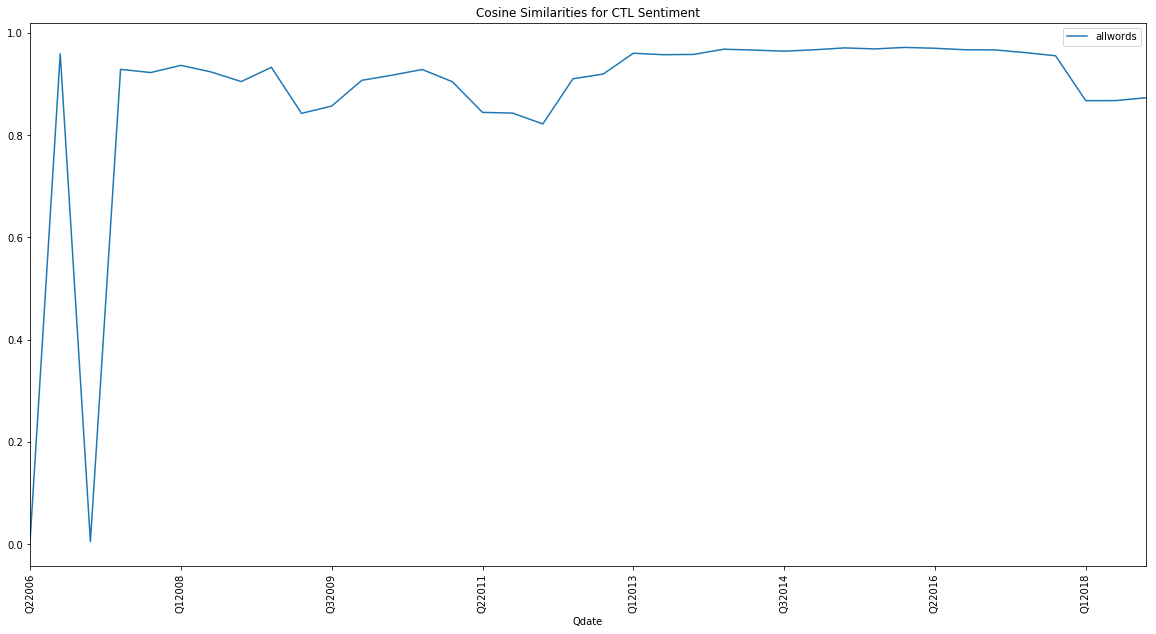

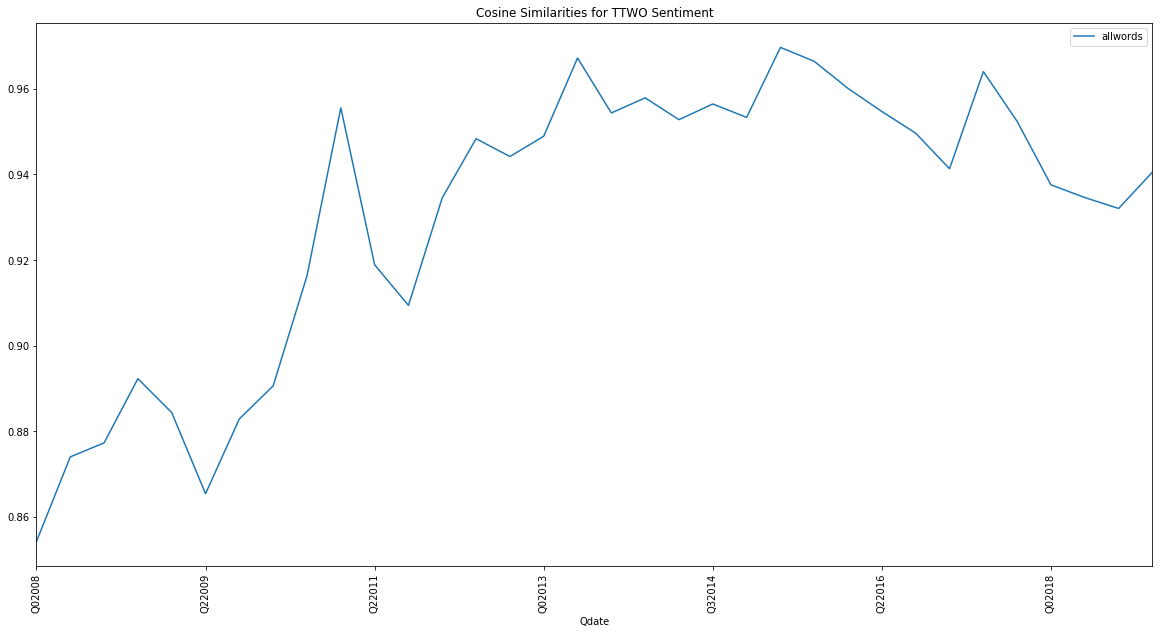

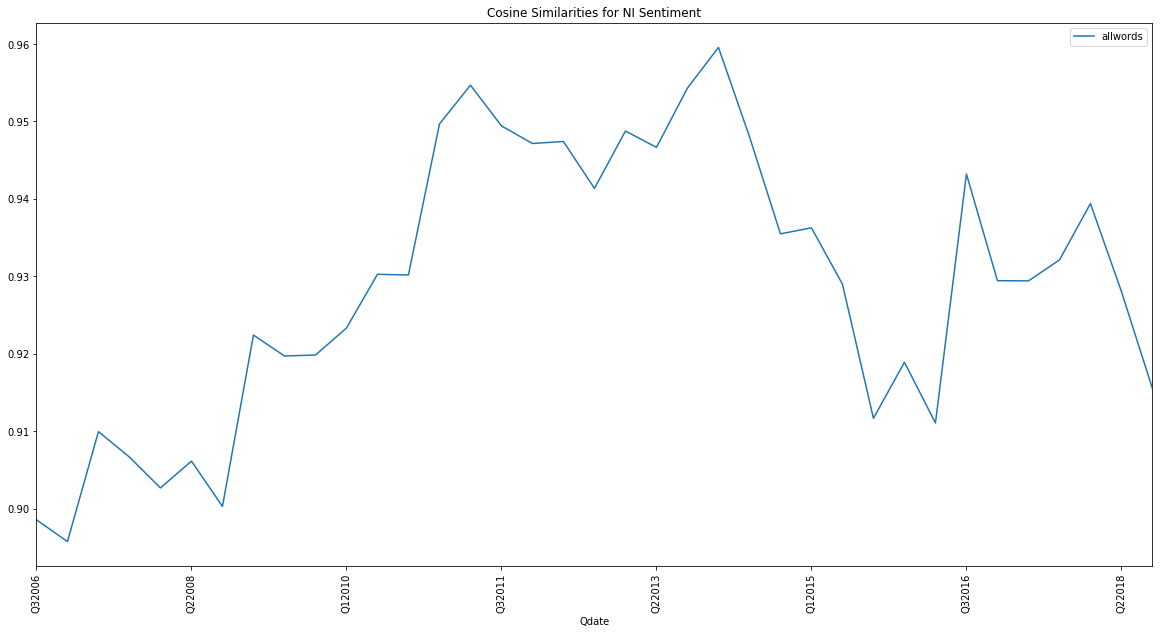

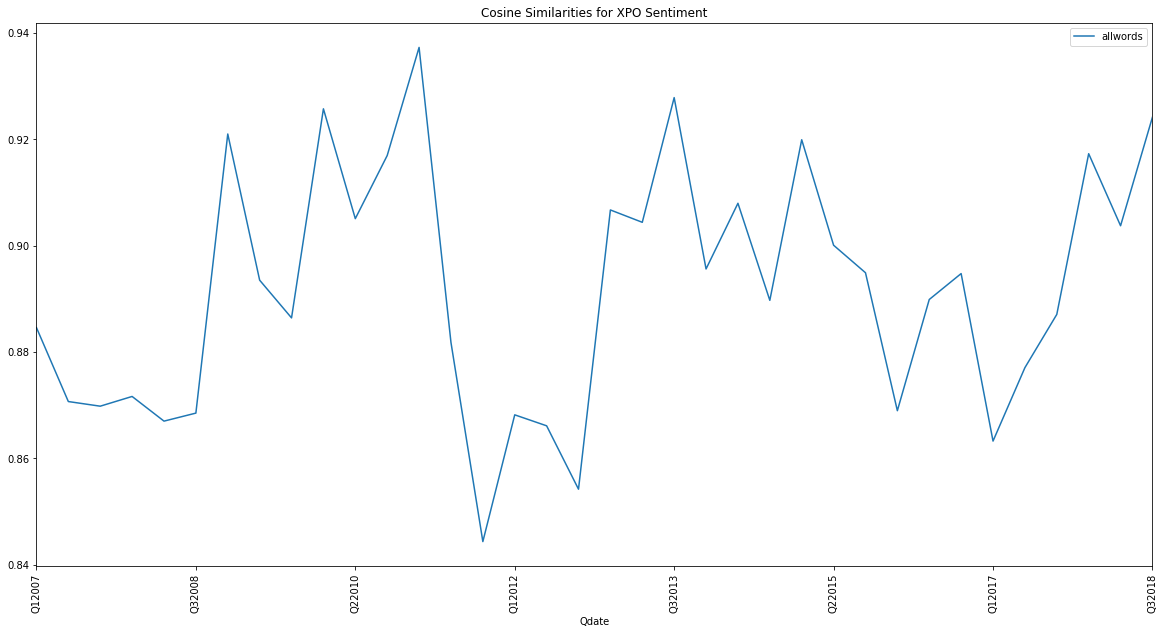

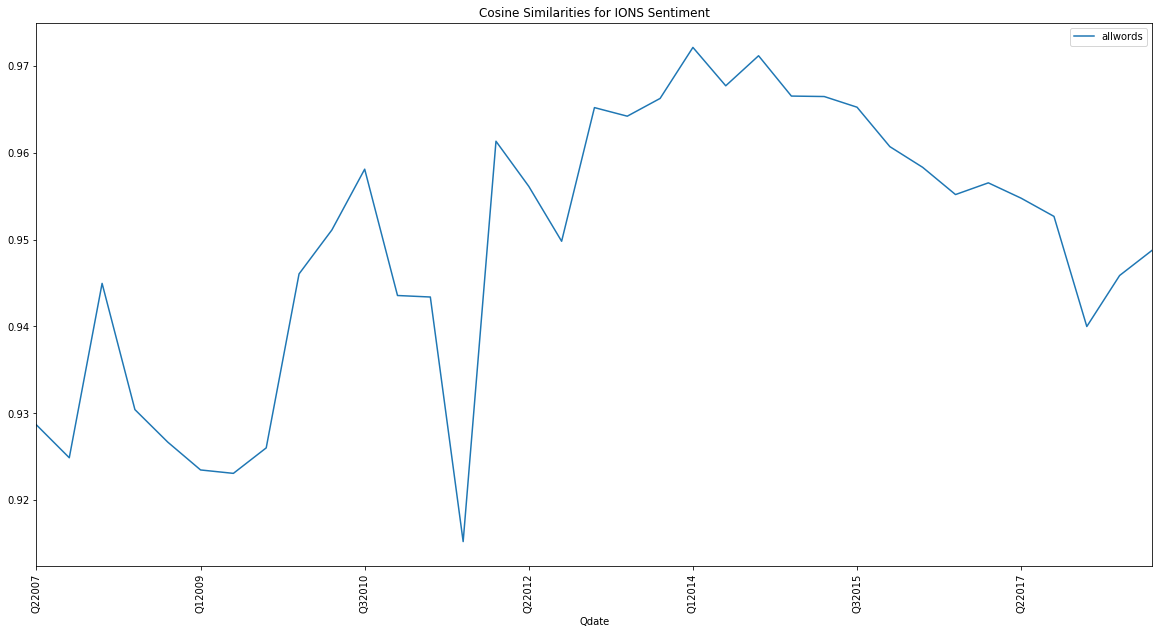

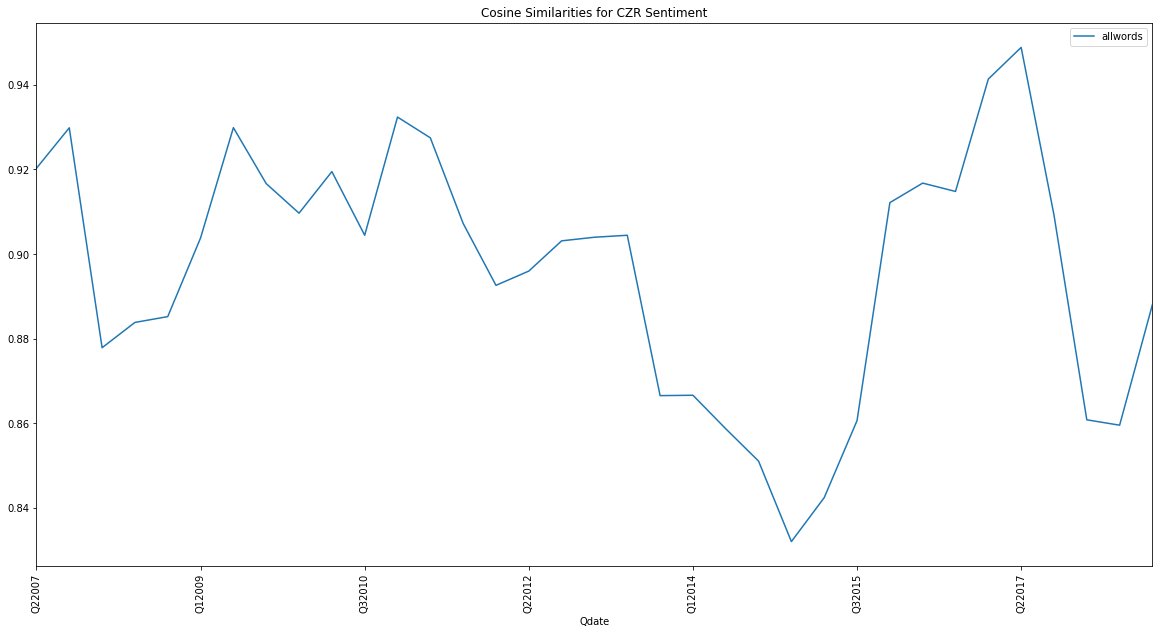

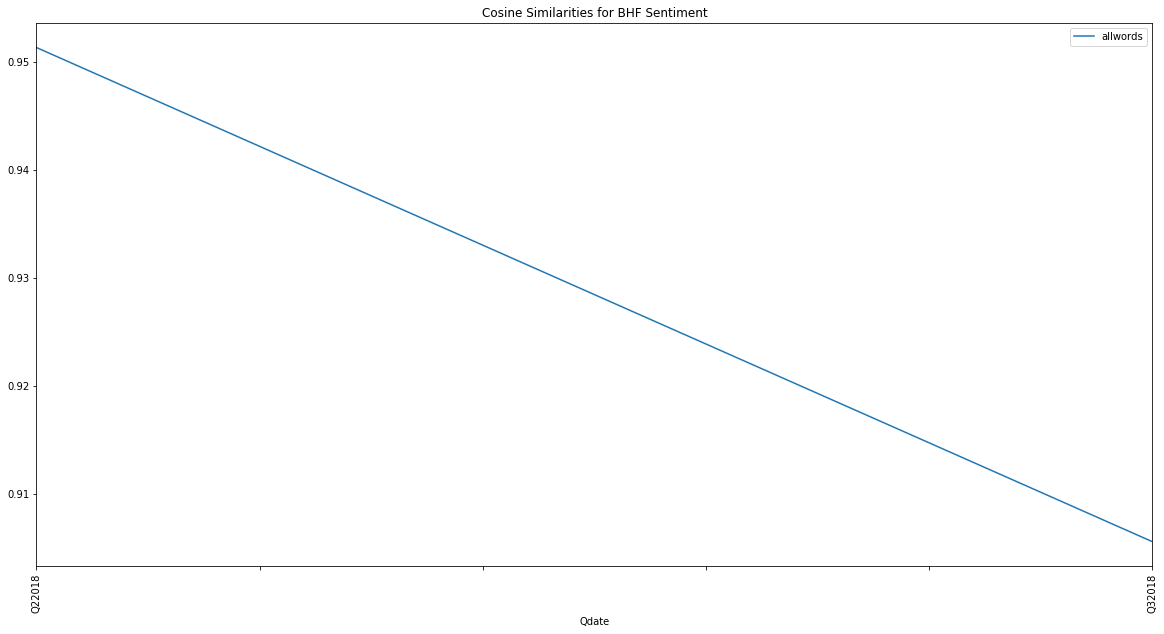

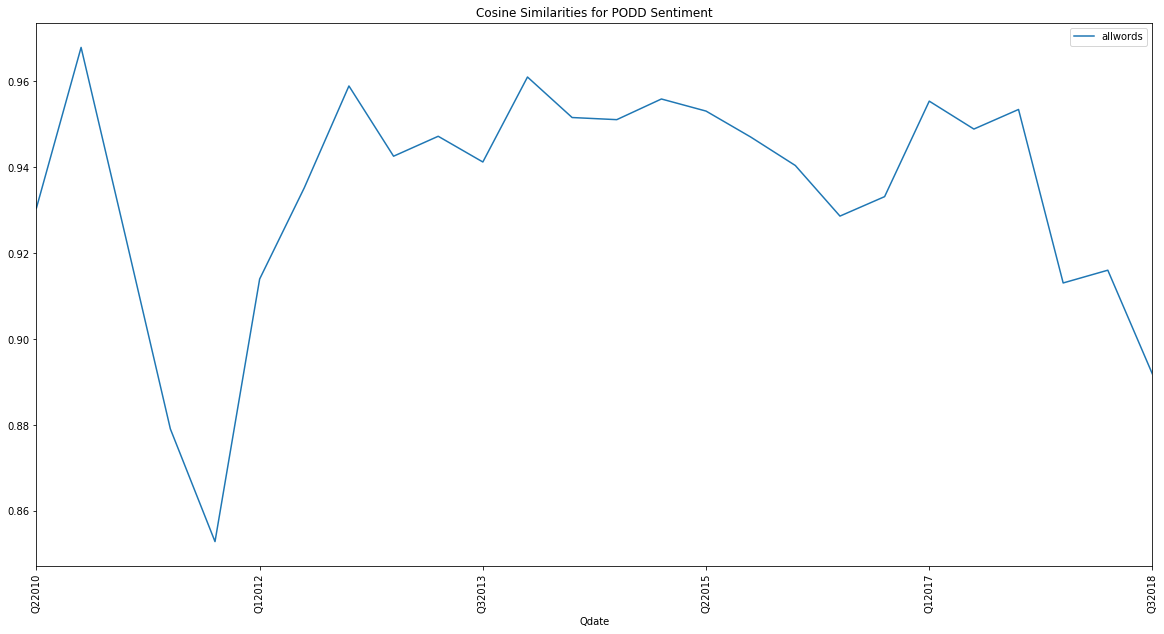

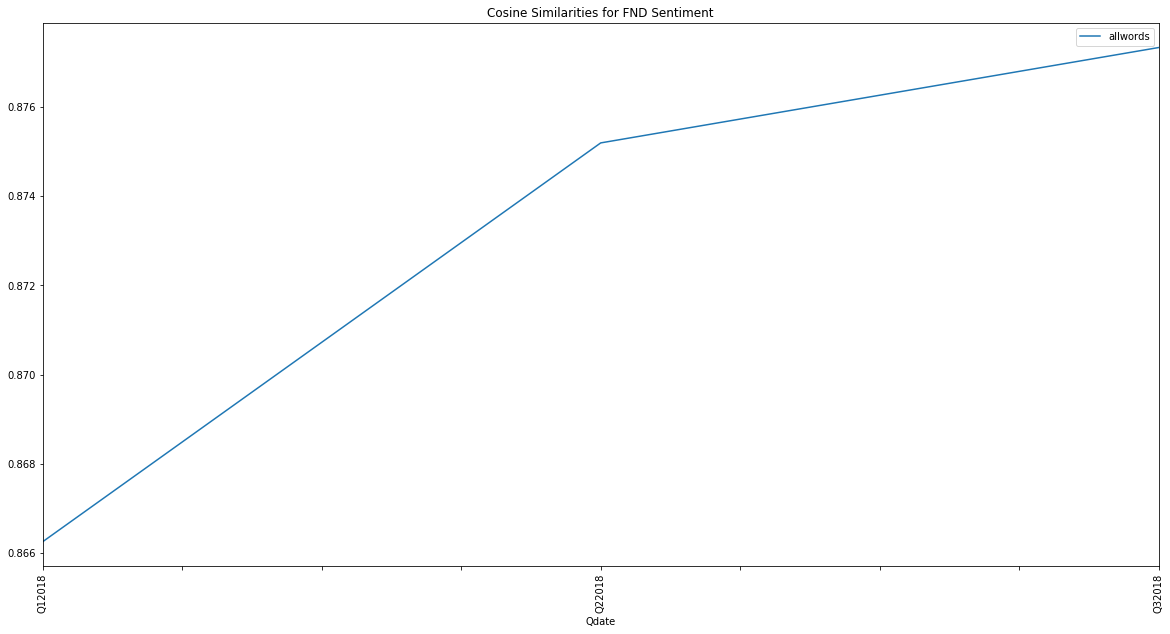

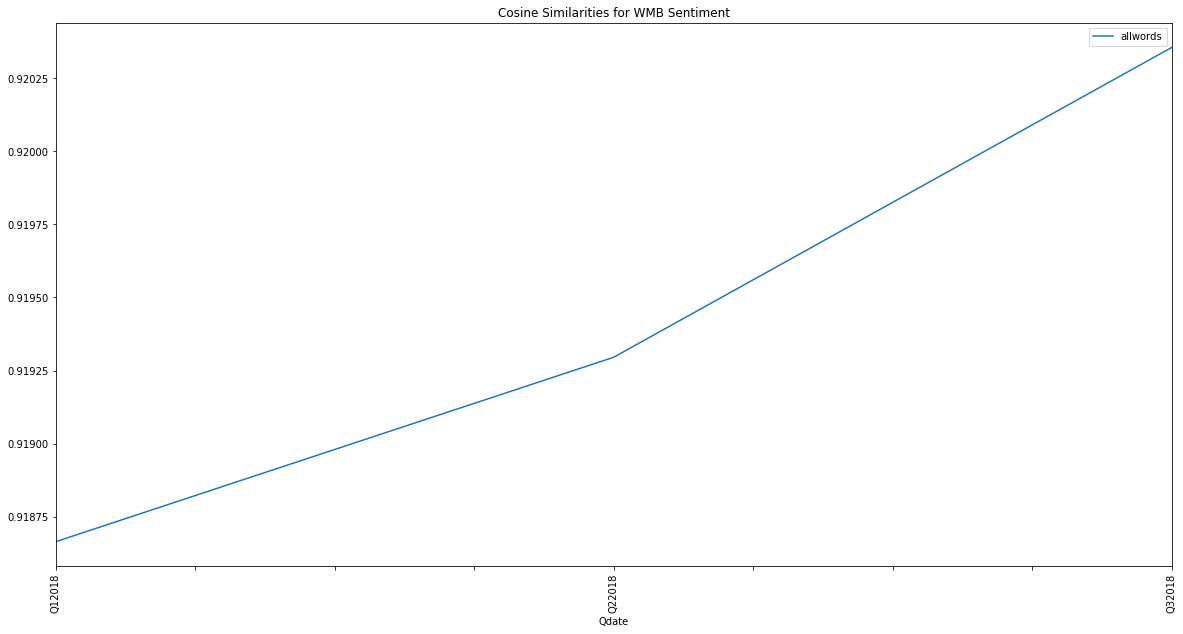

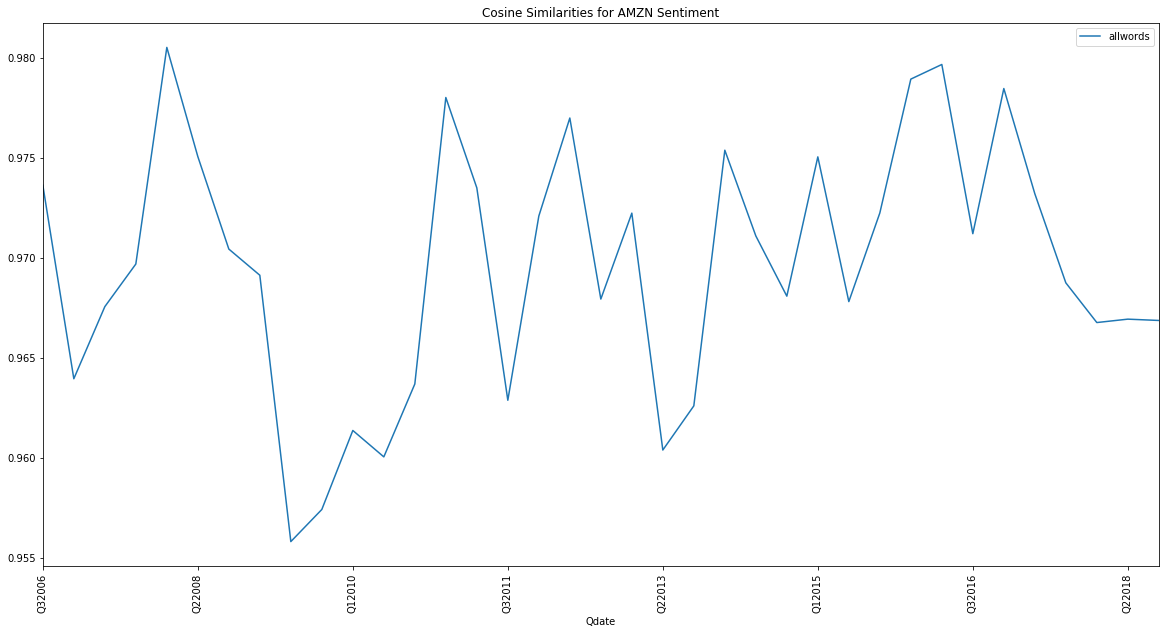

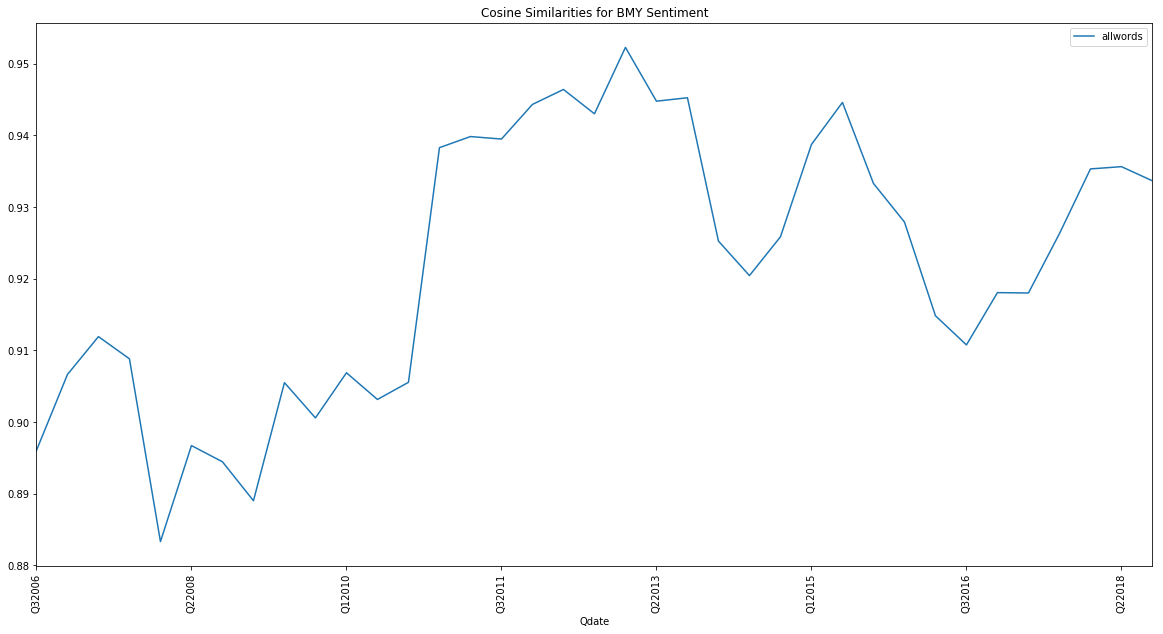

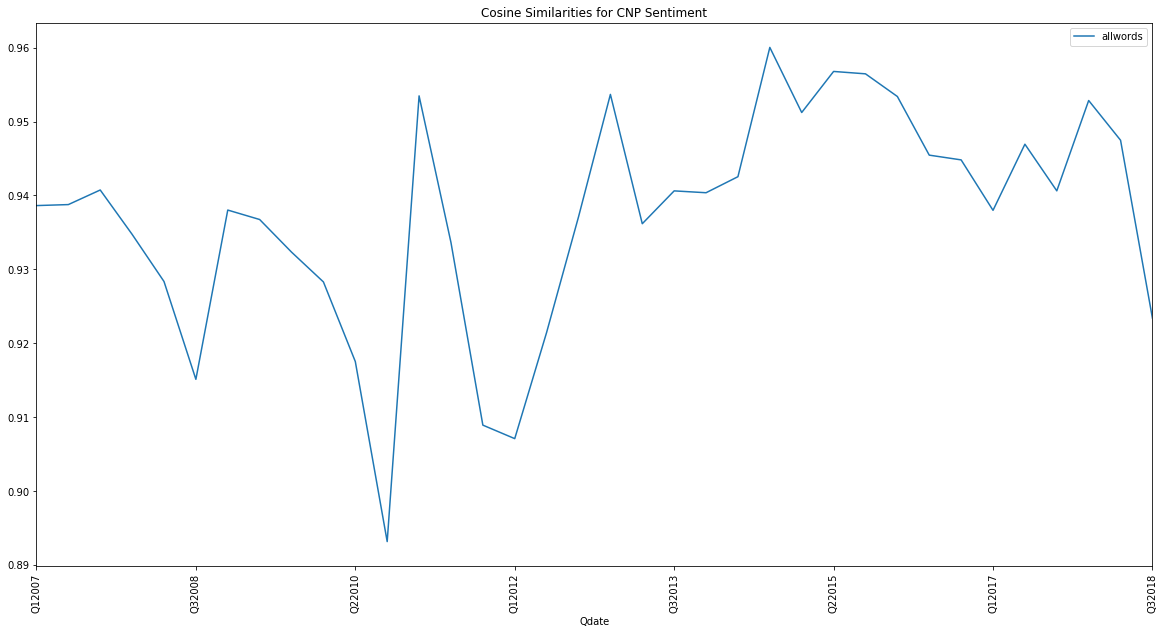

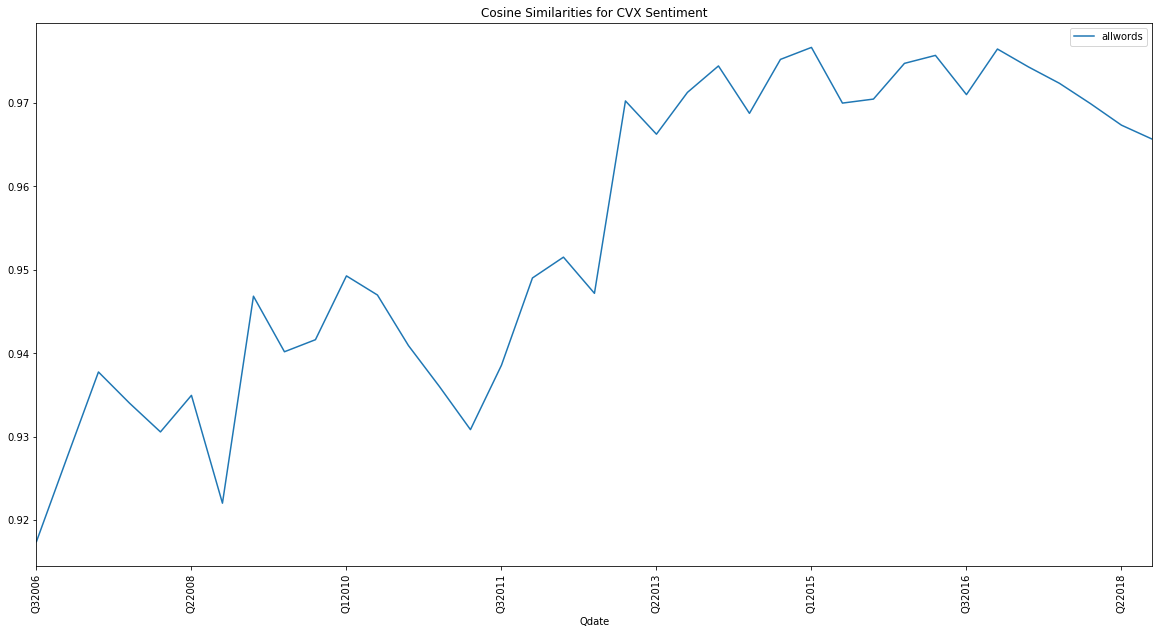

In [56]:
import matplotlib.dates as mdates
for tickers in cik_lookup.keys():
    example_ticker = tickers
    
    cosdfallwords = pd.DataFrame(cosine_similarities[example_ticker])
    cosdfallwords['FileDate'] = file_dates[example_ticker][:-3]
    cosdfallwords['FileDate']=cosdfallwords['FileDate'].astype('datetime64[ns]')
    cosdfallwords['Qdate'] = [('Q'+str(x.quarter-1))+str(x.year) for x in cosdfallwords['FileDate']] #Apply Qdate
    cosdfallwords=cosdfallwords.sort_values(by='FileDate')
    #cosdfallwords=cosdfallwords.set_index('FileDate')
    cosdfallwords=cosdfallwords.set_index('Qdate')

    ax = cosdfallwords.plot(figsize=(20,10),title='Cosine Similarities for {} Sentiment'.format(example_ticker),xticks=None,
          fontsize=10,x_compat=False)
 #   labels = [l.strftime('%m-%y') for l in cosdfallwords.index]
 #   ax.set_xticks(cosdfallwords.index)
 #   ax.set_xticklabels(cosdfallwords.index)
    plt.xticks(rotation=90)
    plt.show()
    